# SWB RT HFA Regressions
Created: 04/08/24 \
Updated: 04/18/2024


In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')




In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [5]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [6]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir = f'{base_dir}ephys_analysis/results/'
subj_info_dir = f'{base_dir}ephys_analysis/subj_info/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

04202024


In [7]:
# Subj list for CCN 2024
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [459]:
# #### Try Beta Power 
# all_subj_beta_power = {}


# beta_range = [13,30]

# # load pow epochs data 
# for subj_id in subj_ids: 
#     # load power epochs for single subject 
#     power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5')[0]
#     power_epochs = power_epochs.crop(tmin=2.0,tmax=5.0,include_tmax=True)
#     power_epochs._data[power_epochs._data > 5] = np.nan # remove all data > zscore 5
# #     power_epochs._data[power_epochs._data < -5] = np.nan # remove all data > zscore 5
#     # save epochs metatdata with noise/IED info and behav regressors (NOT ZSCORED)
# #     power_metadata = power_epochs.metadata
# #     all_subj_metadata[subj_id] = power_metadata
#     # extract power df with mean HFA power for each epoch for each elec 
#     power_df = power_epochs.to_data_frame()
#     del power_epochs 
#     beta_power_df = power_df[(power_df.freq >= beta_range[0])&(power_df.freq <= beta_range[1])].groupby(['epoch']).agg('mean').reset_index()
#     del power_df 
#     all_subj_beta_power[subj_id] = beta_power_df
    
    
# # create a binary pickle file 
# f = open(f'{save_dir}all_subj_beta_power_{date}.pkl',"wb")
# # # write the python object (dict) to pickle file
# pickle.dump(all_subj_beta_power,f)
# # # close file
# f.close()

    

Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_pow_epochs-tfr.h5 ...
Adding metadata with 116 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS003/bp_pow_epochs-tfr.h5 ...
Adding metadata with 92 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_pow_epochs-tfr.h5 ...
Adding metadata with 39 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_pow_epochs-tfr.h5 ...
Adding metadata with 81 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/bp_pow_epochs-tfr.h5 ...
Adding metadata with 75 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_pow_epochs-tfr.h5 ...
Adding metadata with 61 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/bp_pow_epochs-tfr.h5 ...
Adding metadata with 62 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS017/bp_pow_epochs-tfr.h5 ...
Adding metadata with 75 columns

In [8]:
all_subj_beta_power = pickle.load(open(f'{save_dir}all_subj_beta_power_04172024.pkl',"rb"))

## Format Beta Dataframes

In [9]:
metadata_paths = glob(f'{save_dir}all_subj_metadata_*.pkl')
load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
                        for path in metadata_paths]))

all_subj_metadata = pickle.load(open(f'{save_dir}all_subj_metadata_0{load_date}.pkl','rb'))
all_subj_metadata

{'MS002':     lacas1-lacas2 lacas2-lacas3 lacas3-lacas4 lacas4-lacas5 lacas5-lacas6  \
 0            None          None          None          None          None   
 1            None         noise          None          None          None   
 2            None          None          None          None          None   
 3            None          None         noise          None          None   
 4            None          None          None          None          None   
 ..            ...           ...           ...           ...           ...   
 144          None          None          None          None          None   
 145          None          None          None          None          None   
 146          None          None          None          None          None   
 147          None          None          None          None          None   
 148          None          None          None          None          None   
 
     lacas6-lacas7 lacas7-lacas8 lacas8-lacas9 lacas9

In [198]:
# ### need to add Round & RT to all_subj_metadata
# for subj_id in subj_ids:
#     behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
#     subj_metadata = all_subj_metadata[subj_id]
#     subj_metadata['Round'] = behav_df.Round
#     subj_metadata['logRT'] = np.log(behav_df.RT)
#     all_subj_metadata[subj_id] = subj_metadata


In [10]:
#### add roi info to master df 
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/subj_info/roi_reref_labels_master_04132024.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])

beta_master_df = []

# hard coded bc same for all subj
metadata_id_vars = ['epoch','Round','logRT','TrialType', 'SafeBet', 'LowBet', 'HighBet', 'GambleChoice', 'Outcome', 'Profit', 'TotalProfit',
           'GambleEV', 'CR', 'choiceEV', 'RPE', 'totalCPE', 'decisionCPE', 'totalRegret','decisionRegret',
           'totalRelief','decisionRelief','totalCF','decisionCF','pRPE','nRPE']


for subj_id,pow_df in zip(all_subj_beta_power.keys(),all_subj_beta_power.values()):
    pow_df.to_csv(f'{save_dir}{subj_id}_epochs_beta_power.csv')
    # reshape pow_df 
    pow_reg_df = pow_df.melt(id_vars=['epoch','freq'],
                                value_vars=pow_df.columns.drop(['epoch','time','freq']).tolist().copy(),
                                var_name='reref_ch_names', value_name='beta_pow',
                                ignore_index = False)

    pow_reg_df['subj_id'] = subj_id # add subj_id to df values
    # reshape metadata df 
    metadata_df = all_subj_metadata[subj_id].reset_index()
    metadata_df = metadata_df.rename(columns={'index':'epoch'})
    value_vars = np.setdiff1d(metadata_df.columns.tolist(),metadata_id_vars).tolist()
    metadata_reg_df = metadata_df.melt(id_vars=metadata_id_vars,value_vars=value_vars,
                                       var_name='reref_ch_names', value_name='epoch_info',
                                      ignore_index = False)
    
    # merge pow and metadata dfs keeping epoch as index 
    subj_regression_df = pd.merge(pow_reg_df, metadata_reg_df,left_on=['epoch','reref_ch_names'],
                                right_on=['epoch','reref_ch_names']).reset_index(drop=True).set_index('epoch')
    subj_regression_df['epoch_num'] = subj_regression_df.index # keep epoch as a column
    
    # add roi info 
    subj_epochs = pow_reg_df.epoch.unique()
    # extract roi_reref_labels_df for each subj 
    subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
    # add epochs to df - repeat each elec id for every epoch to join with master df 
    subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
    subj_roi_reref_labels = (pd.concat([subj_roi_reref_labels]*len(subj_epochs),
               keys = subj_epochs,
               names = ['epoch',None])).reset_index(level=1,drop=True) #make sure epochs are the index
    subj_roi_reref_labels['epoch_num'] = subj_roi_reref_labels.index

    # create unique reref ch id for regression
    subj_roi_reref_labels['unique_reref_ch'] = subj_roi_reref_labels[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)
    
    # merge regression df with roi reref info df  
    subj_regression_df = pd.merge(subj_regression_df, subj_roi_reref_labels,left_on=['subj_id','reref_ch_names','epoch_num'],
                                right_on=['subj_id','reref_ch_names','epoch_num']).reset_index(drop=True).set_index('epoch_num')
    subj_regression_df['epoch'] = subj_regression_df.index
    beta_master_df.append(subj_regression_df)

    
    
    
beta_master_df = pd.concat(beta_master_df)   
# reorder columns 
beta_master_df = beta_master_df[['subj_id','reref_ch_names','unique_reref_ch','epoch','epoch_info',
                                             'freq','beta_pow','roi', 'hemi','ch_label4roi','ch_type4roi',
                                             'loc4roi','Round','logRT','TrialType','SafeBet', 'LowBet','HighBet', 
                                             'GambleChoice', 'Outcome', 'Profit','TotalProfit', 'GambleEV', 
                                             'CR', 'choiceEV', 'RPE', 'totalCPE','decisionCPE', 'totalRegret',
                                             'decisionRegret', 'totalRelief','decisionRelief', 'totalCF',
                                             'decisionCF', 'pRPE', 'nRPE']]
beta_master_df
    

,subj_id,reref_ch_names,unique_reref_ch,epoch,epoch_info,freq,beta_pow,roi,hemi,ch_label4roi,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
epoch_num,,,,,,,,,,,,,,,,,,,,,
0,MS002,lacas1-lacas2,MS002_lacas1-lacas2,0,None,20.743342,-0.138412,acc,l,lacas1,...,-0.582506,-0.801987,-0.265793,-0.588002,-0.721863,-0.787471,0.624206,0.762781,-0.366683,0.358696
1,MS002,lacas1-lacas2,MS002_lacas1-lacas2,1,None,20.743342,-0.040936,acc,l,lacas1,...,-0.925812,-0.899944,-0.850000,-0.753348,-0.721863,-0.787471,0.042276,-0.304799,-0.366683,-1.384897
2,MS002,lacas1-lacas2,MS002_lacas1-lacas2,2,None,20.743342,-0.041470,acc,l,lacas1,...,1.450231,1.463283,0.610518,0.590083,1.848138,1.933299,0.042276,0.554173,2.425773,0.358696
3,MS002,lacas1-lacas2,MS002_lacas1-lacas2,3,None,20.743342,-0.159911,acc,l,lacas1,...,0.655205,0.875537,0.610518,0.590083,0.501947,0.913010,-0.774467,-0.918351,-0.366683,0.358696
4,MS002,lacas1-lacas2,MS002_lacas1-lacas2,4,None,20.743342,0.158300,acc,l,lacas1,...,1.052718,0.802069,0.610518,0.590083,1.175043,0.785474,0.042276,0.676884,1.694415,0.358696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,145,None,20.743342,-0.011571,vlpfc,r,rmolf12,...,-0.253688,-0.504215,0.337993,0.091387,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127
146,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,146,noise,20.743342,NaN,vlpfc,r,rmolf12,...,-0.416797,-0.755401,0.040726,-0.544720,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127
147,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,147,None,20.743342,-0.123292,vlpfc,r,rmolf12,...,-0.253688,-0.504215,0.337993,0.091387,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127


In [11]:
# reg_df_paths = glob(f'{save_dir}regression_master_df_*.csv')
# load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
#                         for path in reg_df_paths]))
# regression_master_df  = pd.read_csv(f'{save_dir}regression_master_df_0{load_date}.csv') # add 0 bc int strips
### issue with MS002 round num - one of them equals 'K32', must drop that epoch info to turn that round column into integers
beta_master_df = beta_master_df[beta_master_df.Round!='K32']
beta_master_df['Round'] = beta_master_df['Round'].astype(float)
beta_master_df['Round'] = beta_master_df['Round'].astype(int)
beta_master_df


,subj_id,reref_ch_names,unique_reref_ch,epoch,epoch_info,freq,beta_pow,roi,hemi,ch_label4roi,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
epoch_num,,,,,,,,,,,,,,,,,,,,,
0,MS002,lacas1-lacas2,MS002_lacas1-lacas2,0,None,20.743342,-0.138412,acc,l,lacas1,...,-0.582506,-0.801987,-0.265793,-0.588002,-0.721863,-0.787471,0.624206,0.762781,-0.366683,0.358696
1,MS002,lacas1-lacas2,MS002_lacas1-lacas2,1,None,20.743342,-0.040936,acc,l,lacas1,...,-0.925812,-0.899944,-0.850000,-0.753348,-0.721863,-0.787471,0.042276,-0.304799,-0.366683,-1.384897
2,MS002,lacas1-lacas2,MS002_lacas1-lacas2,2,None,20.743342,-0.041470,acc,l,lacas1,...,1.450231,1.463283,0.610518,0.590083,1.848138,1.933299,0.042276,0.554173,2.425773,0.358696
3,MS002,lacas1-lacas2,MS002_lacas1-lacas2,3,None,20.743342,-0.159911,acc,l,lacas1,...,0.655205,0.875537,0.610518,0.590083,0.501947,0.913010,-0.774467,-0.918351,-0.366683,0.358696
4,MS002,lacas1-lacas2,MS002_lacas1-lacas2,4,None,20.743342,0.158300,acc,l,lacas1,...,1.052718,0.802069,0.610518,0.590083,1.175043,0.785474,0.042276,0.676884,1.694415,0.358696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,145,None,20.743342,-0.011571,vlpfc,r,rmolf12,...,-0.253688,-0.504215,0.337993,0.091387,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127
146,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,146,noise,20.743342,NaN,vlpfc,r,rmolf12,...,-0.416797,-0.755401,0.040726,-0.544720,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127
147,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,147,None,20.743342,-0.123292,vlpfc,r,rmolf12,...,-0.253688,-0.504215,0.337993,0.091387,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127


In [12]:
#### clean df for regressions 
# if epoch_info col is None - hfa epoch is good, if not None/null, set equal to null
beta_master_df.beta_pow[~beta_master_df.epoch_info.isnull()] = np.nan
#### clean up df to make regressors numeric
beta_master_df.TrialType.replace(['loss', 'mix', 'gain'],[1,2,3], inplace=True)
# replace safe/gamble choices with 1,2
beta_master_df.GambleChoice.replace(['safe', 'gamble'],[1,2], inplace=True)
# remove fail trials 
beta_master_df = beta_master_df[(beta_master_df.GambleChoice != 'skip')&
                                            (~beta_master_df.GambleChoice.isnull())]
# replace outcome labels with 0,1 and remove no outcome trials
beta_master_df.Outcome.replace(['bad', 'good'],[1,2], inplace=True)
# remove bad trials 
beta_master_df = beta_master_df[~beta_master_df.Outcome.isnull()]

In [13]:
beta_master_df.to_csv(f'{save_dir}beta_master_df_{date}.csv')


In [14]:
beta_master_df.columns

Index(['subj_id', 'reref_ch_names', 'unique_reref_ch', 'epoch', 'epoch_info',
       'freq', 'beta_pow', 'roi', 'hemi', 'ch_label4roi', 'ch_type4roi',
       'loc4roi', 'Round', 'logRT', 'TrialType', 'SafeBet', 'LowBet',
       'HighBet', 'GambleChoice', 'Outcome', 'Profit', 'TotalProfit',
       'GambleEV', 'CR', 'choiceEV', 'RPE', 'totalCPE', 'decisionCPE',
       'totalRegret', 'decisionRegret', 'totalRelief', 'decisionRelief',
       'totalCF', 'decisionCF', 'pRPE', 'nRPE'],
      dtype='object')

# Add RT Information to df

Need to add log RT information to regression master DF dataframe! 
- need to align t+1 RT times with correct t+1 regression df epoch 
- for each epoch in regression master df, need t+1 RT value. 
- drop epochs where there is no reaction time analysis (RT too short or start/end trials)
- epoch numbers for regression df and subj metadata are -1 of actual epoch/round numbers 

In [15]:
### make regression_master_df index = Round to match up rt t+1 
beta_master_df.index = beta_master_df['Round']

In [16]:
### ADD SUBJ RT INFO TO DF
beta_master_df['logRT_t1'] = np.nan


for subj_id in subj_ids:
    subj_reg_df = beta_master_df[beta_master_df.subj_id == subj_id]
    subj_rounds = subj_reg_df.index.unique().tolist()[:-1] # round number of epoch drop last
    subj_rounds_t1 = subj_reg_df.index.unique().tolist()[1:]  # round number of epoch without first idx
    subj_rounds = subj_reg_df.index
    subj_rounds = subj_rounds.unique().tolist()[:-1] # get unique list and subtract last trial (no trial t+1)
    
    for r,r_t1 in list(zip(subj_rounds,subj_rounds_t1)):
        subj_epoch_data = subj_reg_df.loc[r]
        subj_epoch_data.logRT_t1 = subj_reg_df.logRT.loc[r_t1].tolist()[0]
        subj_reg_df.loc[r] = subj_epoch_data
        
    beta_master_df[beta_master_df.subj_id == subj_id] = subj_reg_df
        
        

In [17]:
beta_master_df

,subj_id,reref_ch_names,unique_reref_ch,epoch,epoch_info,freq,beta_pow,roi,hemi,ch_label4roi,...,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE,logRT_t1
Round,,,,,,,,,,,,,,,,,,,,,
1,MS002,lacas1-lacas2,MS002_lacas1-lacas2,0,None,20.743342,-0.138412,acc,l,lacas1,...,-0.801987,-0.265793,-0.588002,-0.721863,-0.787471,0.624206,0.762781,-0.366683,0.358696,0.670167
2,MS002,lacas1-lacas2,MS002_lacas1-lacas2,1,None,20.743342,-0.040936,acc,l,lacas1,...,-0.899944,-0.850000,-0.753348,-0.721863,-0.787471,0.042276,-0.304799,-0.366683,-1.384897,0.459614
3,MS002,lacas1-lacas2,MS002_lacas1-lacas2,2,None,20.743342,-0.041470,acc,l,lacas1,...,1.463283,0.610518,0.590083,1.848138,1.933299,0.042276,0.554173,2.425773,0.358696,0.912929
4,MS002,lacas1-lacas2,MS002_lacas1-lacas2,3,None,20.743342,-0.159911,acc,l,lacas1,...,0.875537,0.610518,0.590083,0.501947,0.913010,-0.774467,-0.918351,-0.366683,0.358696,0.570378
5,MS002,lacas1-lacas2,MS002_lacas1-lacas2,4,None,20.743342,0.158300,acc,l,lacas1,...,0.802069,0.610518,0.590083,1.175043,0.785474,0.042276,0.676884,1.694415,0.358696,0.631657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,145,None,20.743342,-0.011571,vlpfc,r,rmolf12,...,-0.504215,0.337993,0.091387,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127,0.402884
147,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,146,noise,20.743342,NaN,vlpfc,r,rmolf12,...,-0.755401,0.040726,-0.544720,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127,0.577237
148,MS043,rmolf11-rmolf12,MS043_rmolf11-rmolf12,147,None,20.743342,-0.123292,vlpfc,r,rmolf12,...,-0.504215,0.337993,0.091387,-0.700683,-0.739626,0.023358,0.165719,-0.417203,0.454127,0.850039


# HFA Regressions


In [18]:
#### before removing outliers - 
print(beta_master_df.beta_pow.max(),beta_master_df.beta_pow.mean(),beta_master_df.beta_pow.std(),beta_master_df.beta_pow.min())
#https://solomonkurz.netlify.app/blog/2019-02-02-robust-linear-regression-with-student-s-t-distribution/


50.890856348578446 -0.06799504738932508 0.5553060268292866 -2.353336980613853


In [19]:
####### NEW DATA FRAME 
beta_reg_df = beta_master_df.copy()
len(beta_reg_df)

202733

In [18]:
### GAMBLE CHOICE X TRIAL TYPE COLLINEARITY 

vif_df = pd.DataFrame({'logRT_t1':beta_reg_df.logRT_t1,
                       'beta_pow':beta_reg_df.beta_pow,
                       'decisionCPE':beta_reg_df.decisionCPE})



vif_df = vif_df.astype(float)
vif_df = vif_df.dropna(how='any')

vif_data = pd.DataFrame() 
vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

       feature       VIF
0     logRT_t1  1.016960
1     beta_pow  1.016739
2  decisionCPE  1.000304


In [20]:
def run_multi_hfa_model(df, regressor_vars, outcome_var, rand_eff_var):
    # define formula, random effects formula
    formula    = (' + ').join(regressor_vars)
    re_formula = formula
    formula    = f'{outcome_var} ~ 1 + {formula}'
    # run model
    model_fit = smf.mixedlm(
        formula = formula, re_formula = re_formula,
        data = df, groups=df[rand_eff_var], missing='drop').fit()
    
#     model_bic = bic(model_fit)
    return model_fit

# Identify ROI beta encoding of CPEs

In [21]:
var_list = ['C(GambleChoice)','GambleEV','decisionCPE']
outcome_var  = 'beta_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = run_multi_hfa_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         beta_pow    
No. Observations:         190787          Method:                     REML        
No. Groups:               1410            Scale:                      0.2530      
Min. group size:          44              Log-Likelihood:             -142637.8757
Max. group size:          149             Converged:                  Yes         
Mean group size:          135.3                                                   
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                              -0.075    0.007 -11.439 0.000 -0.088 -0.062
C(GambleChoice)[T.2]                    0.005    0.004   1.400 0.162 -0.002  0.012
GambleEV                   

In [54]:
var_list = ['C(GambleChoice)','GambleEV','TotalProfit','decisionCPE']
outcome_var  = 'beta_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = run_multi_hfa_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         beta_pow    
No. Observations:         190787          Method:                     REML        
No. Groups:               1410            Scale:                      0.2519      
Min. group size:          44              Log-Likelihood:             -142538.7391
Max. group size:          149             Converged:                  Yes         
Mean group size:          135.3                                                   
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                              -0.075    0.007 -11.424 0.000 -0.088 -0.062
C(GambleChoice)[T.2]                    0.005    0.004   1.518 0.129 -0.002  0.012
GambleEV                   

In [23]:
var_list = ['decisionCPE']
outcome_var  = 'beta_pow'
rand_eff_var = 'unique_reref_ch'
beta_model_fit = run_multi_hfa_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(beta_model_fit.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    beta_pow    
No. Observations:    190787     Method:                REML        
No. Groups:          1410       Scale:                 0.2550      
Min. group size:     44         Log-Likelihood:        -142867.7549
Max. group size:     149        Converged:             Yes         
Mean group size:     135.3                                         
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               -0.072    0.006 -11.389 0.000 -0.085 -0.060
decisionCPE              0.003    0.001   2.560 0.010  0.001  0.006
Group Var                0.055    0.004                            
Group x decisionCPE Cov  0.001    0.001                            
decisionCPE Var          0.000    0.000                        

In [35]:
f_mat_input = np.identity(len(beta_model_fit.params))[1:,:]
beta_model_fit.f_test(f_mat_input)
beta_model_fit.params[beta_model_fit.pvalues>0.05]

C(GambleChoice)[T.2]                      0.004965
GambleEV                                 -0.000141
C(GambleChoice)[T.2] x GambleEV Cov       0.000860
GambleEV Var                              0.000106
Group x decisionCPE Cov                   0.001914
C(GambleChoice)[T.2] x decisionCPE Cov    0.000796
GambleEV x decisionCPE Cov                0.000240
dtype: float64

In [22]:
# ains_cpe_beta = [val['decisionCPE:beta_pow'] for val in roi_fit.random_effects.values()]
beta_model_cpe = [val['decisionCPE'] for val in beta_model_fit.random_effects.values()]
beta_model_cpe

[0.00463242795429546,
 0.005064083489060556,
 0.0038305778078037284,
 0.0028182239358133096,
 -0.0009716551712738294,
 0.0005554165609689189,
 0.0003144194946763033,
 -0.003938429625559319,
 -0.004852310113208646,
 0.0024606301473117267,
 -3.110169302431129e-05,
 0.003210111945263703,
 0.0011811563163256265,
 0.0021015898015958817,
 0.001966468881678017,
 0.022839837356727993,
 -0.0021040210340344564,
 -0.003847409955379315,
 0.0010440004822774766,
 0.0010710430362992295,
 0.01608674190089114,
 0.011513776278508112,
 0.04420402192722936,
 0.017941818824157556,
 0.021329686601278,
 -0.0008247063029399298,
 -0.005229072104031993,
 -0.006688649748477126,
 -0.0026498532396589244,
 -0.0003813789756697125,
 -0.0012410871337444744,
 -0.0035137897556466163,
 -0.007392833349995618,
 0.010554120465165873,
 0.0016576596865397605,
 0.0008896629565679484,
 -0.004654325994038454,
 0.0023223650791637726,
 0.0006185758120806982,
 -0.0012228233756712825,
 0.0008405385005846863,
 0.0013274939663310327,


In [24]:
# ains_cpe_beta = [val['decisionCPE:beta_pow'] for val in roi_fit.random_effects.values()]
beta_model_cpe = [val['decisionCPE'] for val in beta_model_fit.random_effects.values()]
beta_model_cpe

[0.003373468622104551,
 0.004776291624533151,
 0.0034962327234416895,
 0.0025575669558159197,
 -0.00034644139156061316,
 0.0005527171113242959,
 0.0003658484046599629,
 -0.0032464614213680585,
 -0.004343699617782558,
 0.0018204003887967687,
 -0.0008833424292118608,
 0.002468018204339765,
 0.0007414369568534044,
 0.002193756374971284,
 0.002934105143249212,
 0.018247582952568873,
 -0.0011678662328283723,
 -0.0022609701404061695,
 0.0016840233733027275,
 0.0024789602230974694,
 0.014052145513543435,
 0.009283129006662338,
 0.03735184007793921,
 0.012228556180563772,
 0.01687414569542773,
 -0.001217650915718669,
 -0.004734751051705362,
 -0.005797688726421187,
 -0.0019736929870356073,
 -5.658616367779799e-06,
 -0.0019307004449752982,
 -0.0021872382993344468,
 -0.007592235826720615,
 0.008296418695527401,
 0.0010604987710697593,
 0.0002231336518815878,
 -0.0037635339528679142,
 0.0028376092288659254,
 9.780535190752125e-05,
 0.00024692917015672774,
 0.001272267766259018,
 0.0004699020115828

In [23]:
beta_cpe_results = pd.DataFrame({'unique_reref_ch':list(beta_model_fit.random_effects.keys()),
                                     'beta_model_cpe':beta_model_cpe})
beta_cpe_results

,unique_reref_ch,beta_model_cpe
0,MS002_lacas1-lacas2,0.004632
1,MS002_lacas2-lacas3,0.005064
2,MS002_lacas3-lacas4,0.003831
3,MS002_lacas4-lacas5,0.002818
4,MS002_lacas5-lacas6,-0.000972
...,...,...
1405,MS043_rmolf11-rmolf12,0.001105
1406,MS043_rmolf2-rmolf3,0.000273
1407,MS043_rmolf5-rmolf6,-0.002141
1408,MS043_rmolf6-rmolf7,-0.000933


In [24]:
### sort slopes by ROI
unique_roi_label = []
subj_id_label    = []

for ch in beta_cpe_results.unique_reref_ch:
    unique_roi = beta_reg_df.roi[beta_reg_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    subj_id = beta_reg_df.subj_id[beta_reg_df.unique_reref_ch==ch].unique().item()
    subj_id_label.append(subj_id)
    
beta_cpe_results['roi'] = unique_roi_label
beta_cpe_results['subj_id'] = subj_id_label
beta_cpe_results

,unique_reref_ch,beta_model_cpe,roi,subj_id
0,MS002_lacas1-lacas2,0.004632,acc,MS002
1,MS002_lacas2-lacas3,0.005064,acc,MS002
2,MS002_lacas3-lacas4,0.003831,acc,MS002
3,MS002_lacas4-lacas5,0.002818,acc,MS002
4,MS002_lacas5-lacas6,-0.000972,acc,MS002
...,...,...,...,...
1405,MS043_rmolf11-rmolf12,0.001105,vlpfc,MS043
1406,MS043_rmolf2-rmolf3,0.000273,ofc,MS043
1407,MS043_rmolf5-rmolf6,-0.002141,ofc,MS043
1408,MS043_rmolf6-rmolf7,-0.000933,ofc,MS043


In [25]:
beta_cpe_means_plot = beta_cpe_results.groupby('subj_id').agg('mean')

In [26]:
##### define subset of ROIs to test 
roi_list = ['acc', 'dmpfc', 'amy', 'sts', 'ains', 'vlpfc', 'hpc', 'ofc',
       'pins', 'dlpfc', 'motor', 'vmpfc', 'mcc', 'phg']
beta_cpe_results = beta_cpe_results[beta_cpe_results.roi.isin(roi_list)]
beta_cpe_results


,unique_reref_ch,beta_model_cpe,roi,subj_id
0,MS002_lacas1-lacas2,0.004632,acc,MS002
1,MS002_lacas2-lacas3,0.005064,acc,MS002
2,MS002_lacas3-lacas4,0.003831,acc,MS002
3,MS002_lacas4-lacas5,0.002818,acc,MS002
4,MS002_lacas5-lacas6,-0.000972,acc,MS002
...,...,...,...,...
1405,MS043_rmolf11-rmolf12,0.001105,vlpfc,MS043
1406,MS043_rmolf2-rmolf3,0.000273,ofc,MS043
1407,MS043_rmolf5-rmolf6,-0.002141,ofc,MS043
1408,MS043_rmolf6-rmolf7,-0.000933,ofc,MS043


In [234]:
beta_cpe_results

,unique_reref_ch,beta_model_cpe,roi,subj_id
0,MS002_lacas1-lacas2,0.004632,acc,MS002
1,MS002_lacas2-lacas3,0.005064,acc,MS002
2,MS002_lacas3-lacas4,0.003831,acc,MS002
3,MS002_lacas4-lacas5,0.002818,acc,MS002
4,MS002_lacas5-lacas6,-0.000972,acc,MS002
...,...,...,...,...
1405,MS043_rmolf11-rmolf12,0.001105,vlpfc,MS043
1406,MS043_rmolf2-rmolf3,0.000273,ofc,MS043
1407,MS043_rmolf5-rmolf6,-0.002141,ofc,MS043
1408,MS043_rmolf6-rmolf7,-0.000933,ofc,MS043


In [32]:
roi_list = ['hpc', 'amy', 'ains','acc', 'ofc', 'dmpfc', 'vmpfc','vlpfc']

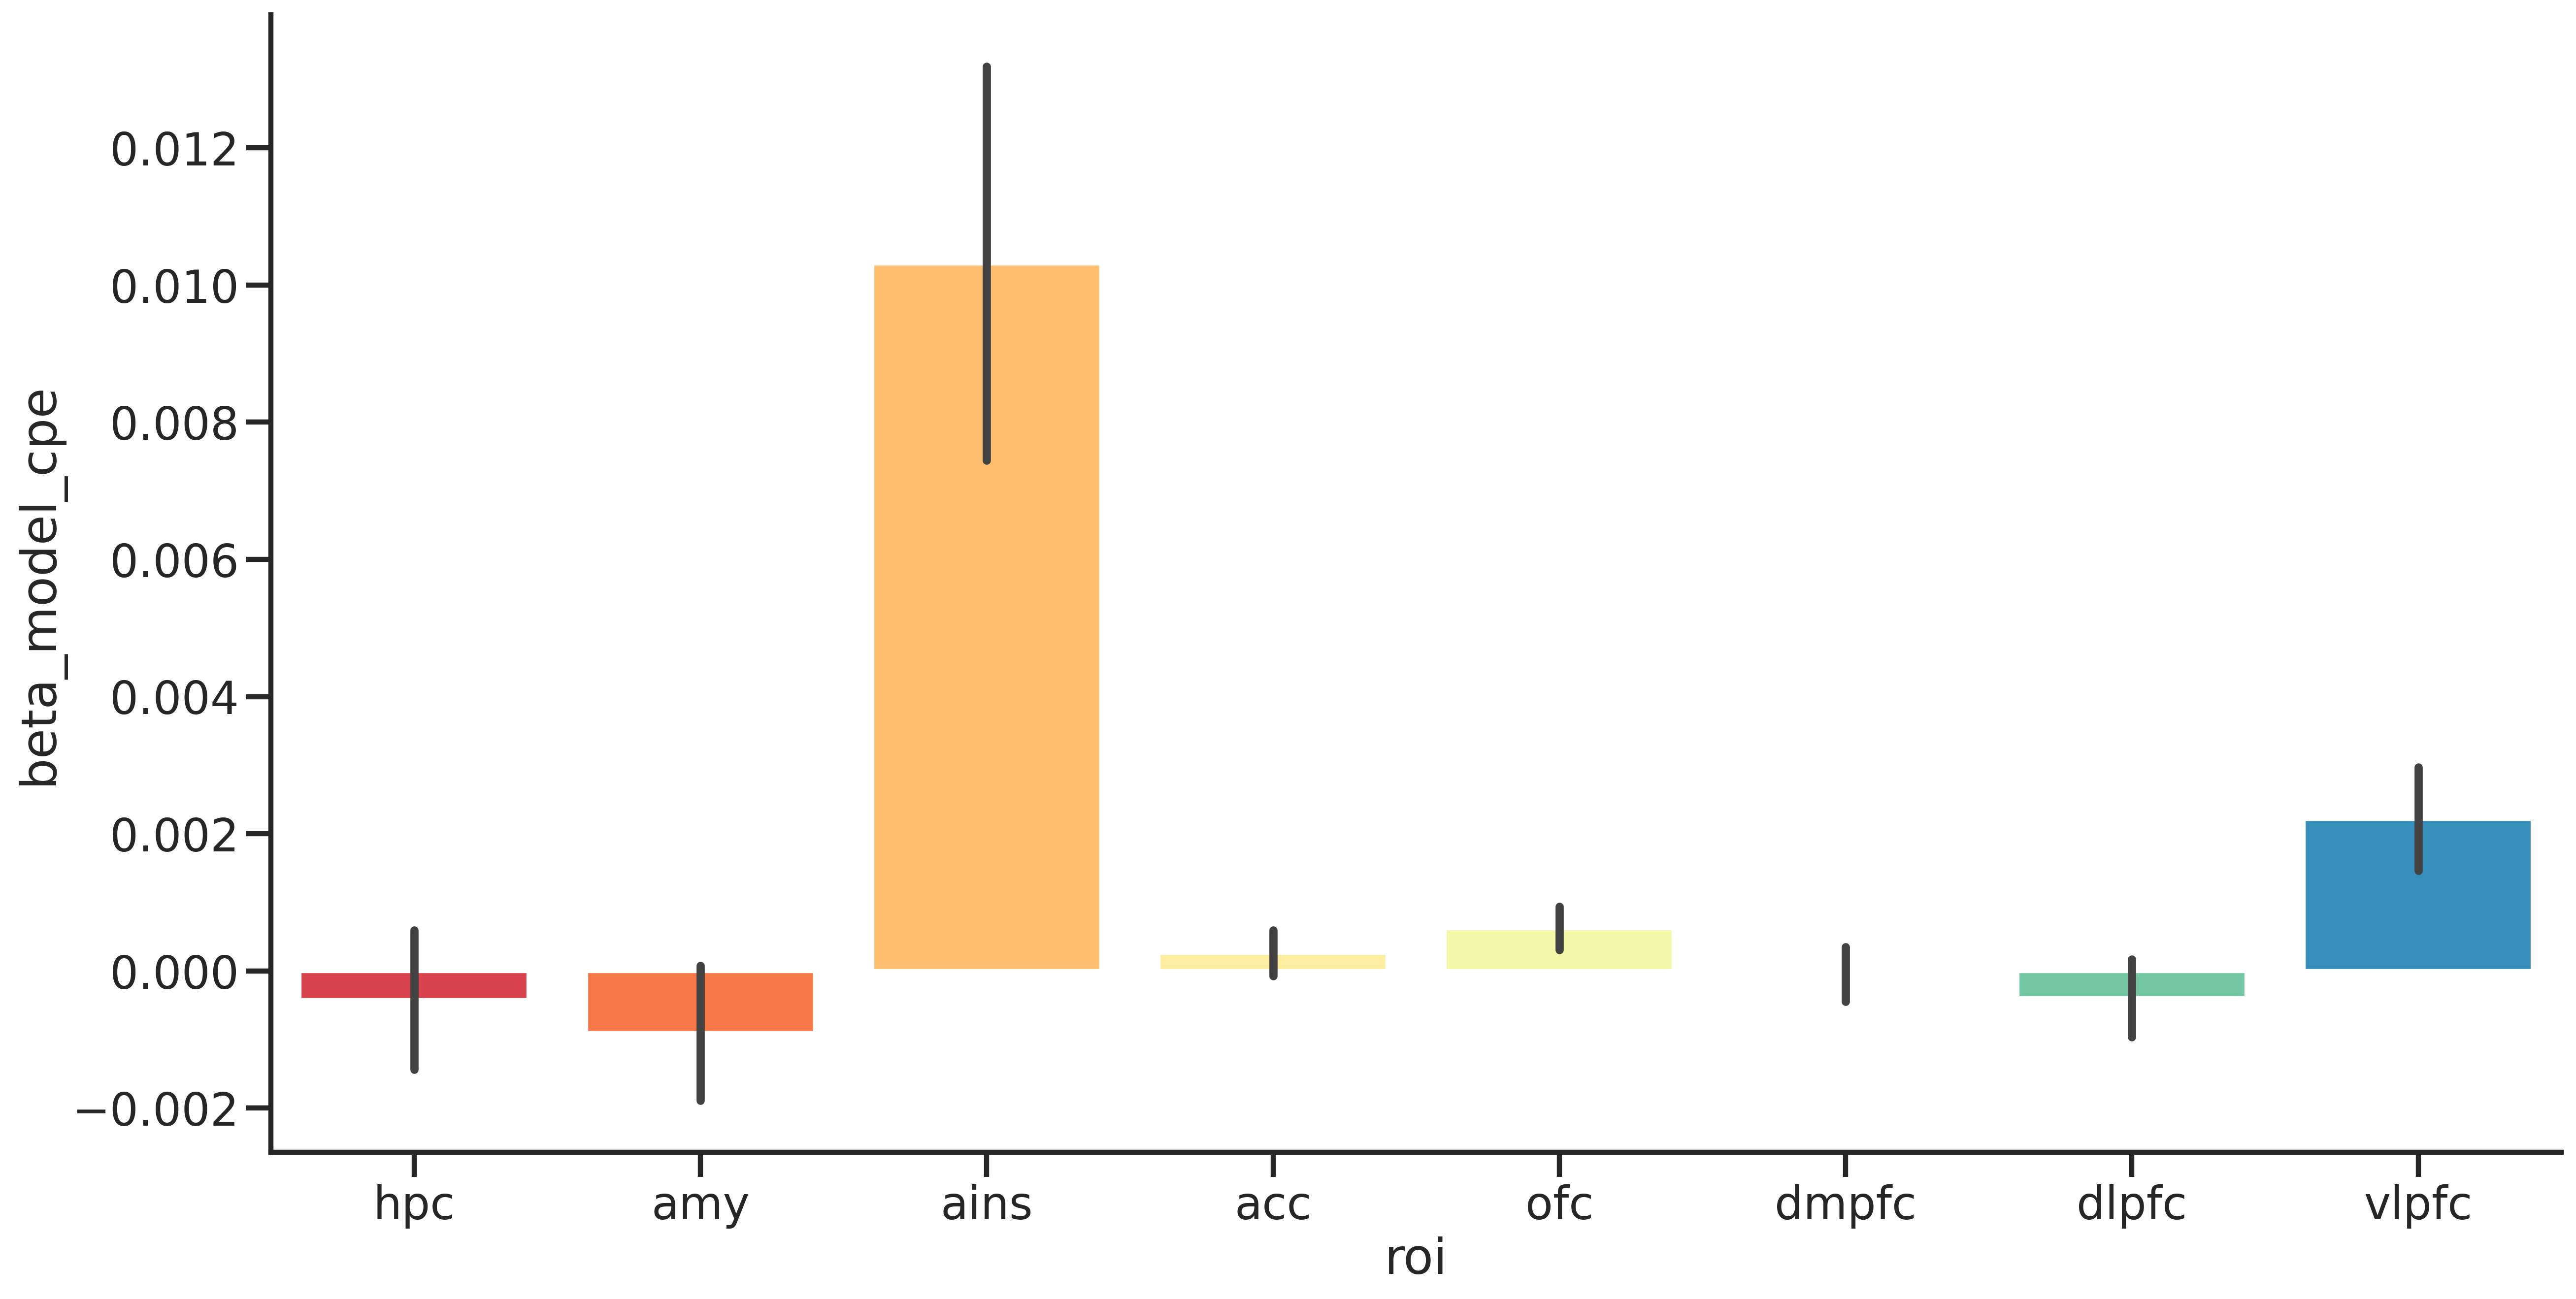

In [55]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

fig_save_dir = f'{base_dir}ephys_analysis/figs/CCN/Beta_Power/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = beta_cpe_results,
              x = beta_cpe_results.roi,
              y = beta_cpe_results.beta_model_cpe,
              palette='Spectral',
              saturation=1,
              order=roi_list,
               errorbar='se',errwidth=4)
sns.despine()
    
plt.savefig(f'{fig_save_dir}/CPE_ROI_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

# Test interaction model on all ROIs

In [42]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

var_list = ['decisionCPE','beta_pow','decisionCPE:beta_pow']
test_model_fit = run_multi_hfa_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(test_model_fit.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1   
No. Observations:          189445          Method:                     REML       
No. Groups:                1410            Scale:                      0.1265     
Min. group size:           44              Log-Likelihood:             -76623.4242
Max. group size:           148             Converged:                  Yes        
Mean group size:           134.4                                                  
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.016    0.005 222.210 0.000  1.007  1.025
decisionCPE                             0.017    0.001  12.926 0.000  0.015  0.020
beta_pow                   

In [41]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

var_list = ['C(GambleChoice)','GambleEV','decisionCPE','beta_pow','decisionCPE:beta_pow']
rt_model_fit = run_multi_hfa_model(beta_reg_df,var_list,outcome_var,rand_eff_var)
print(rt_model_fit.summary())

                           Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            logRT_t1   
No. Observations:             189445             Method:                        REML       
No. Groups:                   1410               Scale:                         0.1253     
Min. group size:              44                 Log-Likelihood:                -75928.0825
Max. group size:              148                Converged:                     No         
Mean group size:              134.4                                                        
-------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                        1.025    0.005 193.672 0.000  1.015  1.035
C(GambleChoice)

In [43]:
rt_model_fit.fe_params

Intercept               1.024880
C(GambleChoice)[T.2]   -0.021101
GambleEV                0.016446
decisionCPE             0.016748
beta_pow               -0.025341
decisionCPE:beta_pow    0.001814
dtype: float64

In [44]:
rt_model_fit.random_effects

{'MS002_lacas1-lacas2': Group                  -0.268697
 C(GambleChoice)[T.2]   -0.040029
 GambleEV                0.017243
 decisionCPE             0.013804
 beta_pow                0.032213
 decisionCPE:beta_pow    0.002055
 dtype: float64,
 'MS002_lacas2-lacas3': Group                  -0.262167
 C(GambleChoice)[T.2]   -0.039763
 GambleEV                0.014167
 decisionCPE             0.009512
 beta_pow                0.004866
 decisionCPE:beta_pow   -0.010333
 dtype: float64,
 'MS002_lacas3-lacas4': Group                  -0.266295
 C(GambleChoice)[T.2]   -0.039818
 GambleEV                0.016255
 decisionCPE             0.013064
 beta_pow                0.053972
 decisionCPE:beta_pow    0.005361
 dtype: float64,
 'MS002_lacas4-lacas5': Group                  -0.271679
 C(GambleChoice)[T.2]   -0.039902
 GambleEV                0.019358
 decisionCPE             0.016768
 beta_pow               -0.002610
 decisionCPE:beta_pow    0.011145
 dtype: float64,
 'MS002_lacas5-lacas6': 

In [45]:
# elec_rand_int = [val['Group'] for val in rt_model_fit.random_effects.values()]+rt_model_fit.fe_params['Intercept']
# elec_rand_cpe = [val['decisionCPE'] for val in rt_model_fit.random_effects.values()]+rt_model_fit.fe_params['decisionCPE']
# elec_rand_hfa = [val['hfa_pow'] for val in rt_model_fit.random_effects.values()]+rt_model_fit.fe_params['hfa_pow']
# elec_rand_cpe_hfa = [val['decisionCPE:hfa_pow'] for val in rt_model_fit.random_effects.values()]+rt_model_fit.fe_params['decisionCPE:hfa_pow']


# elec_rand_int = [val['Group'] for val in rt_model_fit.random_effects.values()]
# elec_rand_cpe = [val['decisionCPE'] for val in rt_model_fit.random_effects.values()]
# elec_rand_hfa = [val['hfa_pow'] for val in rt_model_fit.random_effects.values()]
# elec_rand_cpe_hfa = [val['decisionCPE:hfa_pow'] for val in rt_model_fit.random_effects.values()]


elec_rand_int = [val['Group'] for val in rt_model_fit.random_effects.values()]
elec_rand_cpe = [val['decisionCPE'] for val in rt_model_fit.random_effects.values()]
elec_rand_beta = [val['beta_pow'] for val in rt_model_fit.random_effects.values()]
elec_rand_cpe_beta = [val['decisionCPE:beta_pow'] for val in rt_model_fit.random_effects.values()]





In [46]:
rt_cpe_beta_results = pd.DataFrame({'unique_reref_ch':list(rt_model_fit.random_effects.keys()),
                                     'rand_intercepts':elec_rand_int,
                                     'rand_cpe_slopes':elec_rand_cpe,
                                  'rand_beta_slopes':elec_rand_beta,
                                  'rand_cpe_beta_slopes':elec_rand_cpe_beta})
rt_cpe_beta_results

,unique_reref_ch,rand_intercepts,rand_cpe_slopes,rand_beta_slopes,rand_cpe_beta_slopes
0,MS002_lacas1-lacas2,-0.268697,0.013804,0.032213,0.002055
1,MS002_lacas2-lacas3,-0.262167,0.009512,0.004866,-0.010333
2,MS002_lacas3-lacas4,-0.266295,0.013064,0.053972,0.005361
3,MS002_lacas4-lacas5,-0.271679,0.016768,-0.002610,0.011145
4,MS002_lacas5-lacas6,-0.271544,0.014310,-0.024623,0.022268
...,...,...,...,...,...
1405,MS043_rmolf11-rmolf12,-0.297718,-0.000464,0.023630,-0.001067
1406,MS043_rmolf2-rmolf3,-0.302072,0.002928,-0.000922,-0.014037
1407,MS043_rmolf5-rmolf6,-0.300326,0.002069,0.019824,0.011847
1408,MS043_rmolf6-rmolf7,-0.297204,-0.003899,-0.021300,0.017147


In [47]:
### sort slopes by ROI
unique_roi_label = []
subj_id_label    = []

for ch in rt_cpe_beta_results.unique_reref_ch:
    unique_roi = beta_reg_df.roi[beta_reg_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    subj_id = beta_reg_df.subj_id[beta_reg_df.unique_reref_ch==ch].unique().item()
    subj_id_label.append(subj_id)
    
rt_cpe_beta_results['roi'] = unique_roi_label
rt_cpe_beta_results['subj_id'] = subj_id_label
rt_cpe_beta_results


,unique_reref_ch,rand_intercepts,rand_cpe_slopes,rand_beta_slopes,rand_cpe_beta_slopes,roi,subj_id
0,MS002_lacas1-lacas2,-0.268697,0.013804,0.032213,0.002055,acc,MS002
1,MS002_lacas2-lacas3,-0.262167,0.009512,0.004866,-0.010333,acc,MS002
2,MS002_lacas3-lacas4,-0.266295,0.013064,0.053972,0.005361,acc,MS002
3,MS002_lacas4-lacas5,-0.271679,0.016768,-0.002610,0.011145,acc,MS002
4,MS002_lacas5-lacas6,-0.271544,0.014310,-0.024623,0.022268,acc,MS002
...,...,...,...,...,...,...,...
1405,MS043_rmolf11-rmolf12,-0.297718,-0.000464,0.023630,-0.001067,vlpfc,MS043
1406,MS043_rmolf2-rmolf3,-0.302072,0.002928,-0.000922,-0.014037,ofc,MS043
1407,MS043_rmolf5-rmolf6,-0.300326,0.002069,0.019824,0.011847,ofc,MS043
1408,MS043_rmolf6-rmolf7,-0.297204,-0.003899,-0.021300,0.017147,ofc,MS043


In [48]:
rt_cpe_beta_results['roi'].value_counts()

dmpfc            188
acc              168
ofc              155
sts              105
dlpfc             89
amy               84
hpc               84
temporal          77
vlpfc             72
ains              50
pins              46
thalamus          36
mcc               28
phg               23
parietal          22
motor             17
vmpfc             17
temporal pole     12
caudate            3
pcc                1
Name: roi, dtype: int64

In [49]:
##### define subset of ROIs to test 
roi_list = ['hpc', 'amy', 'ains','acc', 'ofc', 'dmpfc', 'dlpfc','vlpfc']

In [50]:
rt_cpe_beta_plot = rt_cpe_beta_results.copy()
# good_roi = full_hfa_model_results['roi'].value_counts().index[full_hfa_model_results['roi'].value_counts()>20].to_list()
rt_cpe_beta_plot = rt_cpe_beta_plot[rt_cpe_beta_plot.roi.isin(roi_list)]
rt_cpe_beta_plot


,unique_reref_ch,rand_intercepts,rand_cpe_slopes,rand_beta_slopes,rand_cpe_beta_slopes,roi,subj_id
0,MS002_lacas1-lacas2,-0.268697,0.013804,0.032213,0.002055,acc,MS002
1,MS002_lacas2-lacas3,-0.262167,0.009512,0.004866,-0.010333,acc,MS002
2,MS002_lacas3-lacas4,-0.266295,0.013064,0.053972,0.005361,acc,MS002
3,MS002_lacas4-lacas5,-0.271679,0.016768,-0.002610,0.011145,acc,MS002
4,MS002_lacas5-lacas6,-0.271544,0.014310,-0.024623,0.022268,acc,MS002
...,...,...,...,...,...,...,...
1405,MS043_rmolf11-rmolf12,-0.297718,-0.000464,0.023630,-0.001067,vlpfc,MS043
1406,MS043_rmolf2-rmolf3,-0.302072,0.002928,-0.000922,-0.014037,ofc,MS043
1407,MS043_rmolf5-rmolf6,-0.300326,0.002069,0.019824,0.011847,ofc,MS043
1408,MS043_rmolf6-rmolf7,-0.297204,-0.003899,-0.021300,0.017147,ofc,MS043


In [1]:
rt_cpe_beta_plot['roi'].value_counts()

NameError: name 'rt_cpe_beta_plot' is not defined

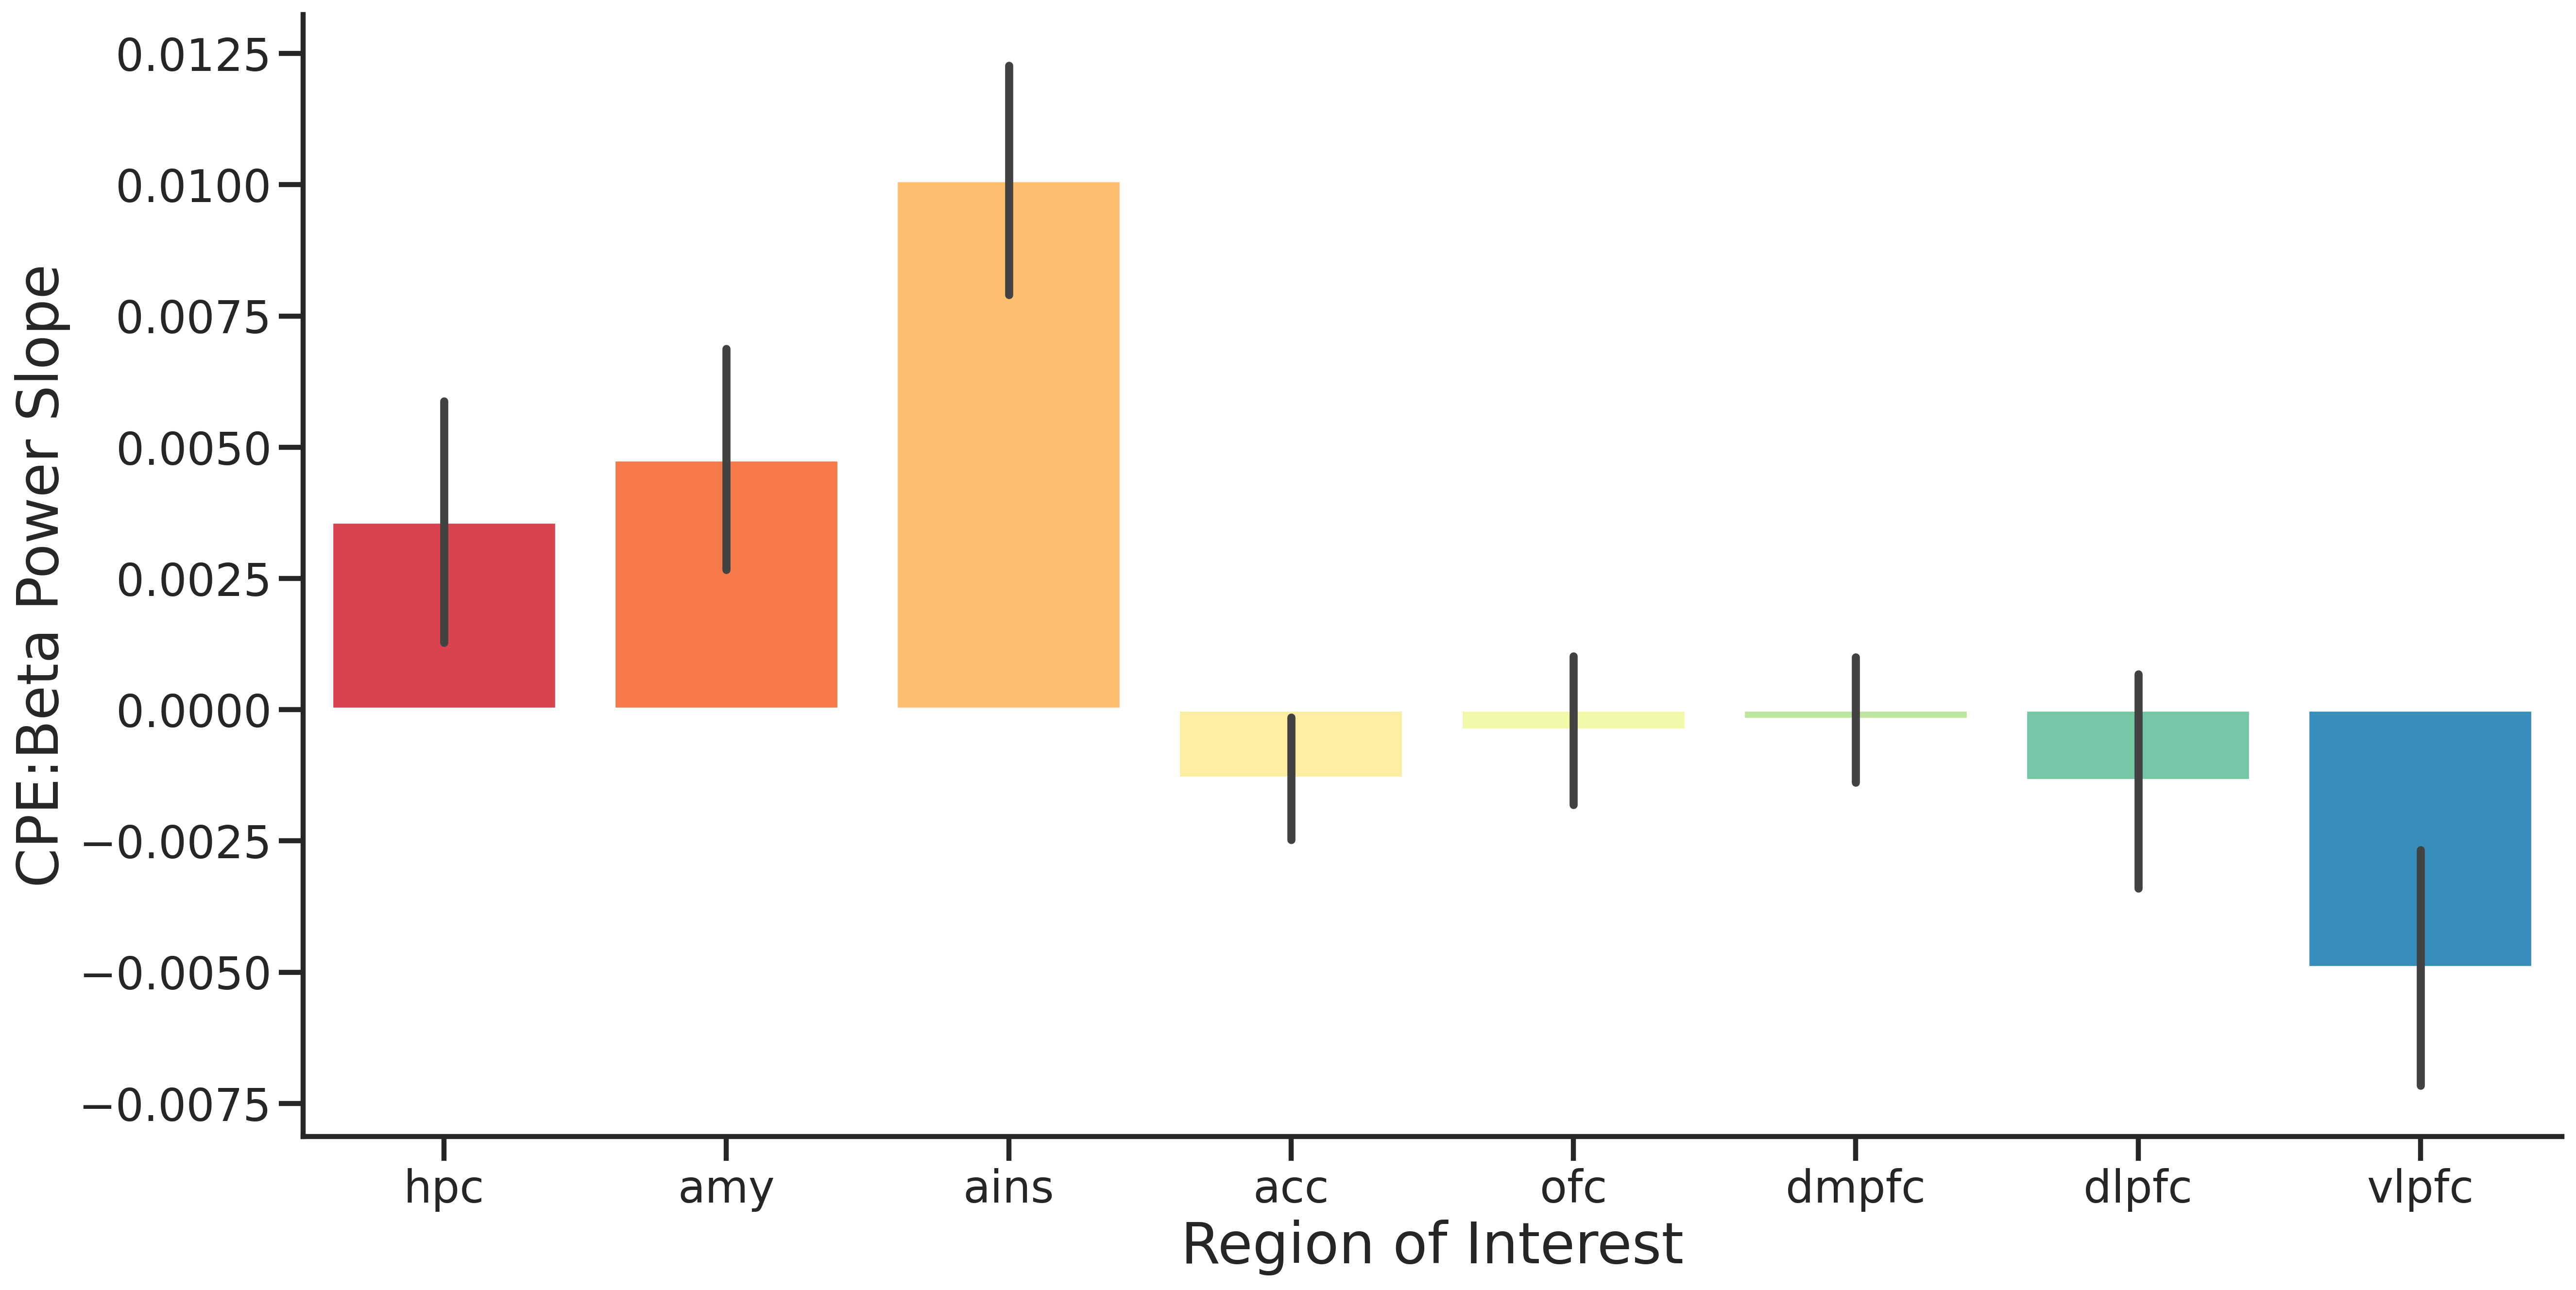

In [54]:

sns.set_theme(style='ticks') 
sns.set_context("poster")
# sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

fig_save_dir = f'{base_dir}ephys_analysis/figs/CCN/Beta_Power/'
os.makedirs(fig_save_dir,exist_ok=True)
    

sns.barplot(data = rt_cpe_beta_plot,x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes, 
            palette = 'Spectral', #tab20c #RdYlGn #viridis
            saturation = 1,
           errwidth=4,
           errorbar='se',
           order=roi_list)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Power Slope',fontsize=28,x=0.1)
plt.xlabel('Region of Interest',fontsize=28,y=-0.03)
sns.despine()


plt.savefig(f'{fig_save_dir}/InteractionBetas_ROI_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,
facecolor='auto', edgecolor='auto',dpi=500,
backend=None)



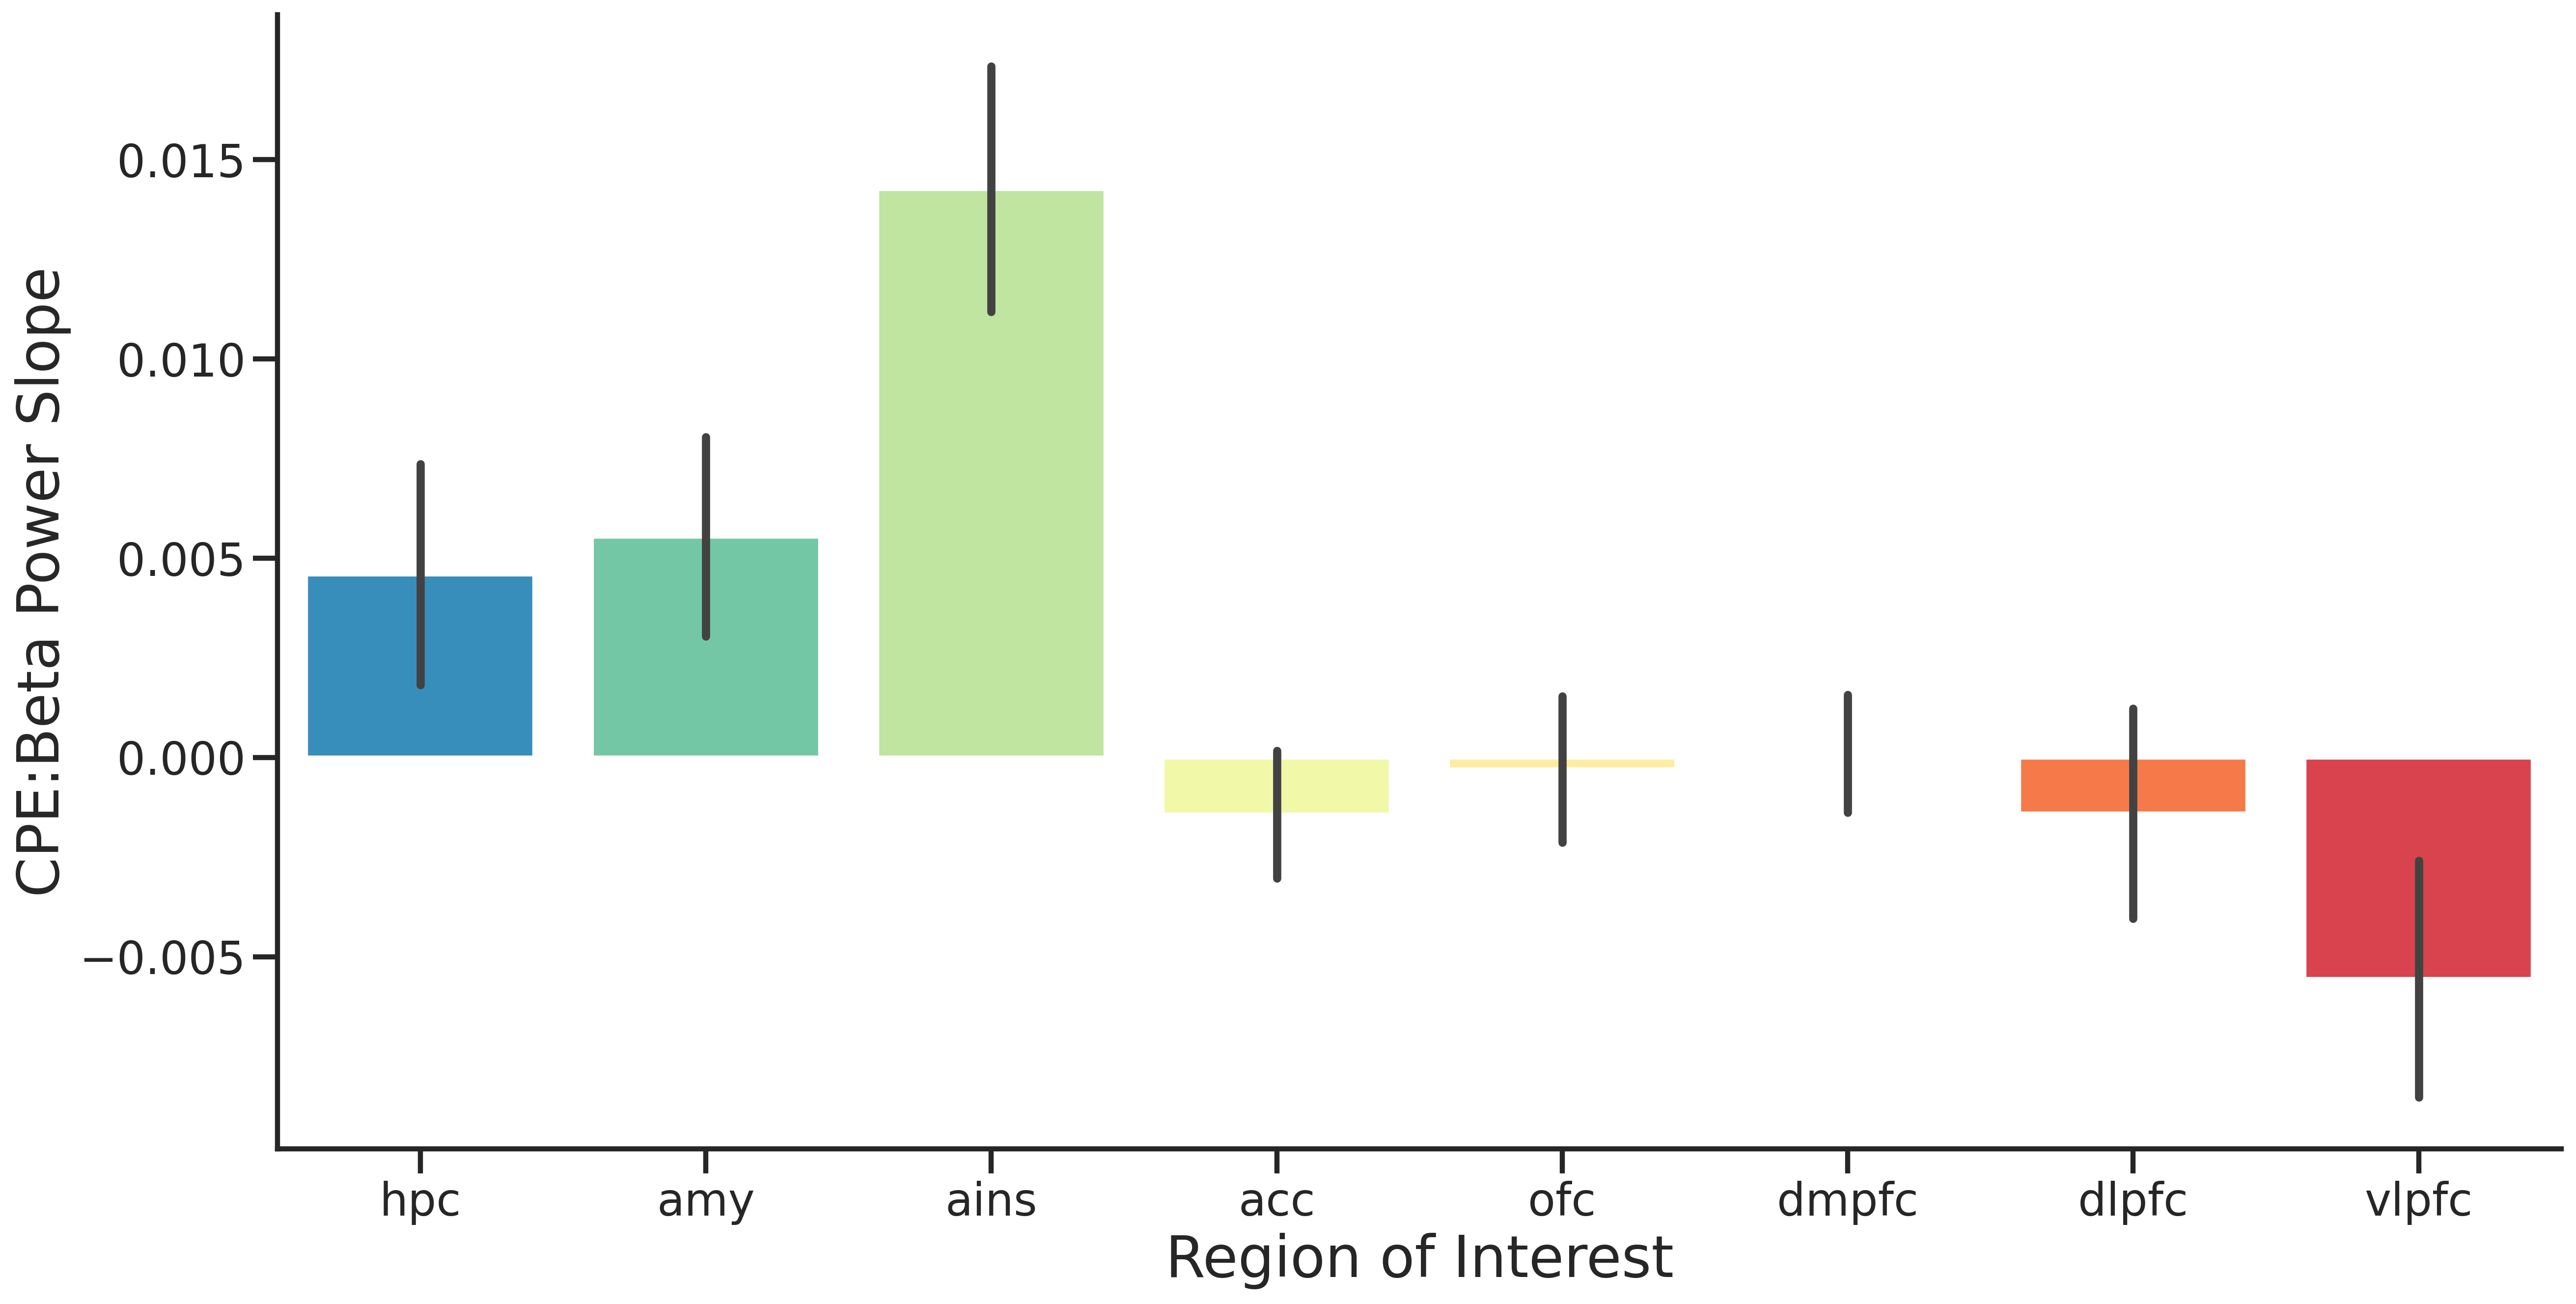

In [231]:

sns.set_theme(style='ticks') 
sns.set_context("poster")
# sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes, 
            palette = 'Spectral_r', #tab20c
            saturation = 1,
           errwidth=4,
           errorbar='se',
           order=roi_list)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Power Slope',fontsize=28,x=0.1)
plt.xlabel('Region of Interest',fontsize=28,y=-0.03)
sns.despine()

In [38]:
###### define vars for model
roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','beta_pow','decisionCPE:beta_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

ains_df = beta_reg_df[(beta_reg_df.roi == 'ains')]
ains_fit = run_multi_hfa_model(ains_df,roi_vars,outcome_var,rand_eff_var)

    
amy_df = beta_reg_df[(beta_reg_df.roi == 'amy')]
amy_fit = run_multi_hfa_model(amy_df,roi_vars,outcome_var,rand_eff_var)


In [39]:
ains_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                        MixedLM            Dependent Variable:            logRT_t1  
No. Observations:             6618               Method:                        REML      
No. Groups:                   50                 Scale:                         0.1426    
Min. group size:              91                 Log-Likelihood:                -3069.6008
Max. group size:              146                Converged:                     Yes       
Mean group size:              132.4                                                       
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.945    0.022 42.774 0.000  0.901  0.988
C(GambleChoice)[T.2]                            -0.042    0.011 -3.680 0.000 -0.065 -0.020
GambleEV                                         0.029    0.007  4.011 0.000  0.015  0.043
decisionCPE                                      0.020    0.006  3.265 0.001  0.008  0.032
beta_pow                                        -0.034    0.011 -3.024 0.002 -0.056 -0.012
decisionCPE:beta_pow                             0.021    0.009  2.373 0.018  0.004  0.037
Group Var                                        0.021    0.010                           
Group x C(GambleChoice)[T.2] Cov                 0.002    0.006                           
C(GambleChoice)[T.2] Var                         0.000    0.001                           
Group x GambleEV Cov                            -0.003    0.003                           
C(GambleChoice)[T.2] x GambleEV Cov             -0.000    0.002                           
GambleEV Var                                     0.001    0.001                           
Group x decisionCPE Cov                          0.000    0.003                           
C(GambleChoice)[T.2] x decisionCPE Cov          -0.000    0.001                           
GambleEV x decisionCPE Cov                       0.000    0.001                           
decisionCPE Var                                  0.001    0.002                           
Group x beta_pow Cov                             0.002    0.004                           
C(GambleChoice)[T.2] x beta_pow Cov              0.000    0.002                           
GambleEV x beta_pow Cov                         -0.000    0.002                           
decisionCPE x beta_pow Cov                       0.000                                    
beta_pow Var                                     0.001    0.001                           
Group x decisionCPE:beta_pow Cov                -0.002    0.003                           
C(GambleChoice)[T.2] x decisionCPE:beta_pow Cov -0.000                                    
GambleEV x decisionCPE:beta_pow Cov              0.000                                    
decisionCPE x decisionCPE:beta_pow Cov           0.000                                    
beta_pow x decisionCPE:beta_pow Cov             -0.000                                    
decisionCPE:beta_pow Var                         0.000                                    
==========================================================================================

"""

In [40]:
amy_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                        MixedLM            Dependent Variable:            logRT_t1  
No. Observations:             11029              Method:                        REML      
No. Groups:                   84                 Scale:                         0.1272    
Min. group size:              94                 Log-Likelihood:                -4522.2063
Max. group size:              146                Converged:                     Yes       
Mean group size:              131.3                                                       
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        1.027    0.027 38.461 0.000  0.975  1.079
C(GambleChoice)[T.2]                            -0.026    0.009 -2.760 0.006 -0.044 -0.008
GambleEV                                         0.018    0.004  4.003 0.000  0.009  0.026
decisionCPE                                      0.019    0.005  4.111 0.000  0.010  0.028
beta_pow                                        -0.004                                    
decisionCPE:beta_pow                             0.016    0.004  3.495 0.000  0.007  0.024
Group Var                                        0.057    0.033                           
Group x C(GambleChoice)[T.2] Cov                 0.011    0.016                           
C(GambleChoice)[T.2] Var                         0.002    0.003                           
Group x GambleEV Cov                            -0.003    0.005                           
C(GambleChoice)[T.2] x GambleEV Cov             -0.001    0.001                           
GambleEV Var                                     0.000    0.001                           
Group x decisionCPE Cov                         -0.003    0.004                           
C(GambleChoice)[T.2] x decisionCPE Cov          -0.001    0.002                           
GambleEV x decisionCPE Cov                       0.000    0.001                           
decisionCPE Var                                  0.001    0.001                           
Group x beta_pow Cov                            -0.002                                    
C(GambleChoice)[T.2] x beta_pow Cov             -0.000    0.001                           
GambleEV x beta_pow Cov                          0.000    0.001                           
decisionCPE x beta_pow Cov                      -0.000    0.001                           
beta_pow Var                                     0.000                                    
Group x decisionCPE:beta_pow Cov                -0.002                                    
C(GambleChoice)[T.2] x decisionCPE:beta_pow Cov -0.001    0.002                           
GambleEV x decisionCPE:beta_pow Cov              0.000    0.001                           
decisionCPE x decisionCPE:beta_pow Cov          -0.000    0.001                           
beta_pow x decisionCPE:beta_pow Cov              0.000                                    
decisionCPE:beta_pow Var                         0.001    0.001                           
==========================================================================================

"""

In [ ]:
ains_cpe_beta = [val['decisionCPE:beta_pow'] for val in ains_fit.random_effects.values()]
amy_cpe_beta = [val['decisionCPE:beta_pow'] for val in amy_fit.random_effects.values()]


# rt_cpe_beta_results = pd.DataFrame({'unique_reref_ch':list(rt_model_fit.random_effects.keys()),
#                                      'rand_intercepts':elec_rand_int,
#                                      'rand_cpe_slopes':elec_rand_cpe,
#                                   'rand_beta_slopes':elec_rand_beta,
#                                   'rand_cpe_beta_slopes':elec_rand_cpe_beta})
# rt_cpe_beta_results


In [ ]:
### sort slopes by ROI
unique_roi_label = []
subj_id_label    = []

for ch in rt_cpe_beta_results.unique_reref_ch:
    unique_roi = beta_reg_df.roi[beta_reg_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    subj_id = beta_reg_df.subj_id[beta_reg_df.unique_reref_ch==ch].unique().item()
    subj_id_label.append(subj_id)
    
rt_cpe_beta_results['roi'] = unique_roi_label
rt_cpe_beta_results['subj_id'] = subj_id_label
rt_cpe_beta_results


In [ ]:
rt_cpe_beta_plot = rt_cpe_beta_results.copy()
# good_roi = full_hfa_model_results['roi'].value_counts().index[full_hfa_model_results['roi'].value_counts()>20].to_list()
rt_cpe_beta_plot = rt_cpe_beta_plot[rt_cpe_beta_plot.roi.isin(roi_list)]
rt_cpe_beta_plot

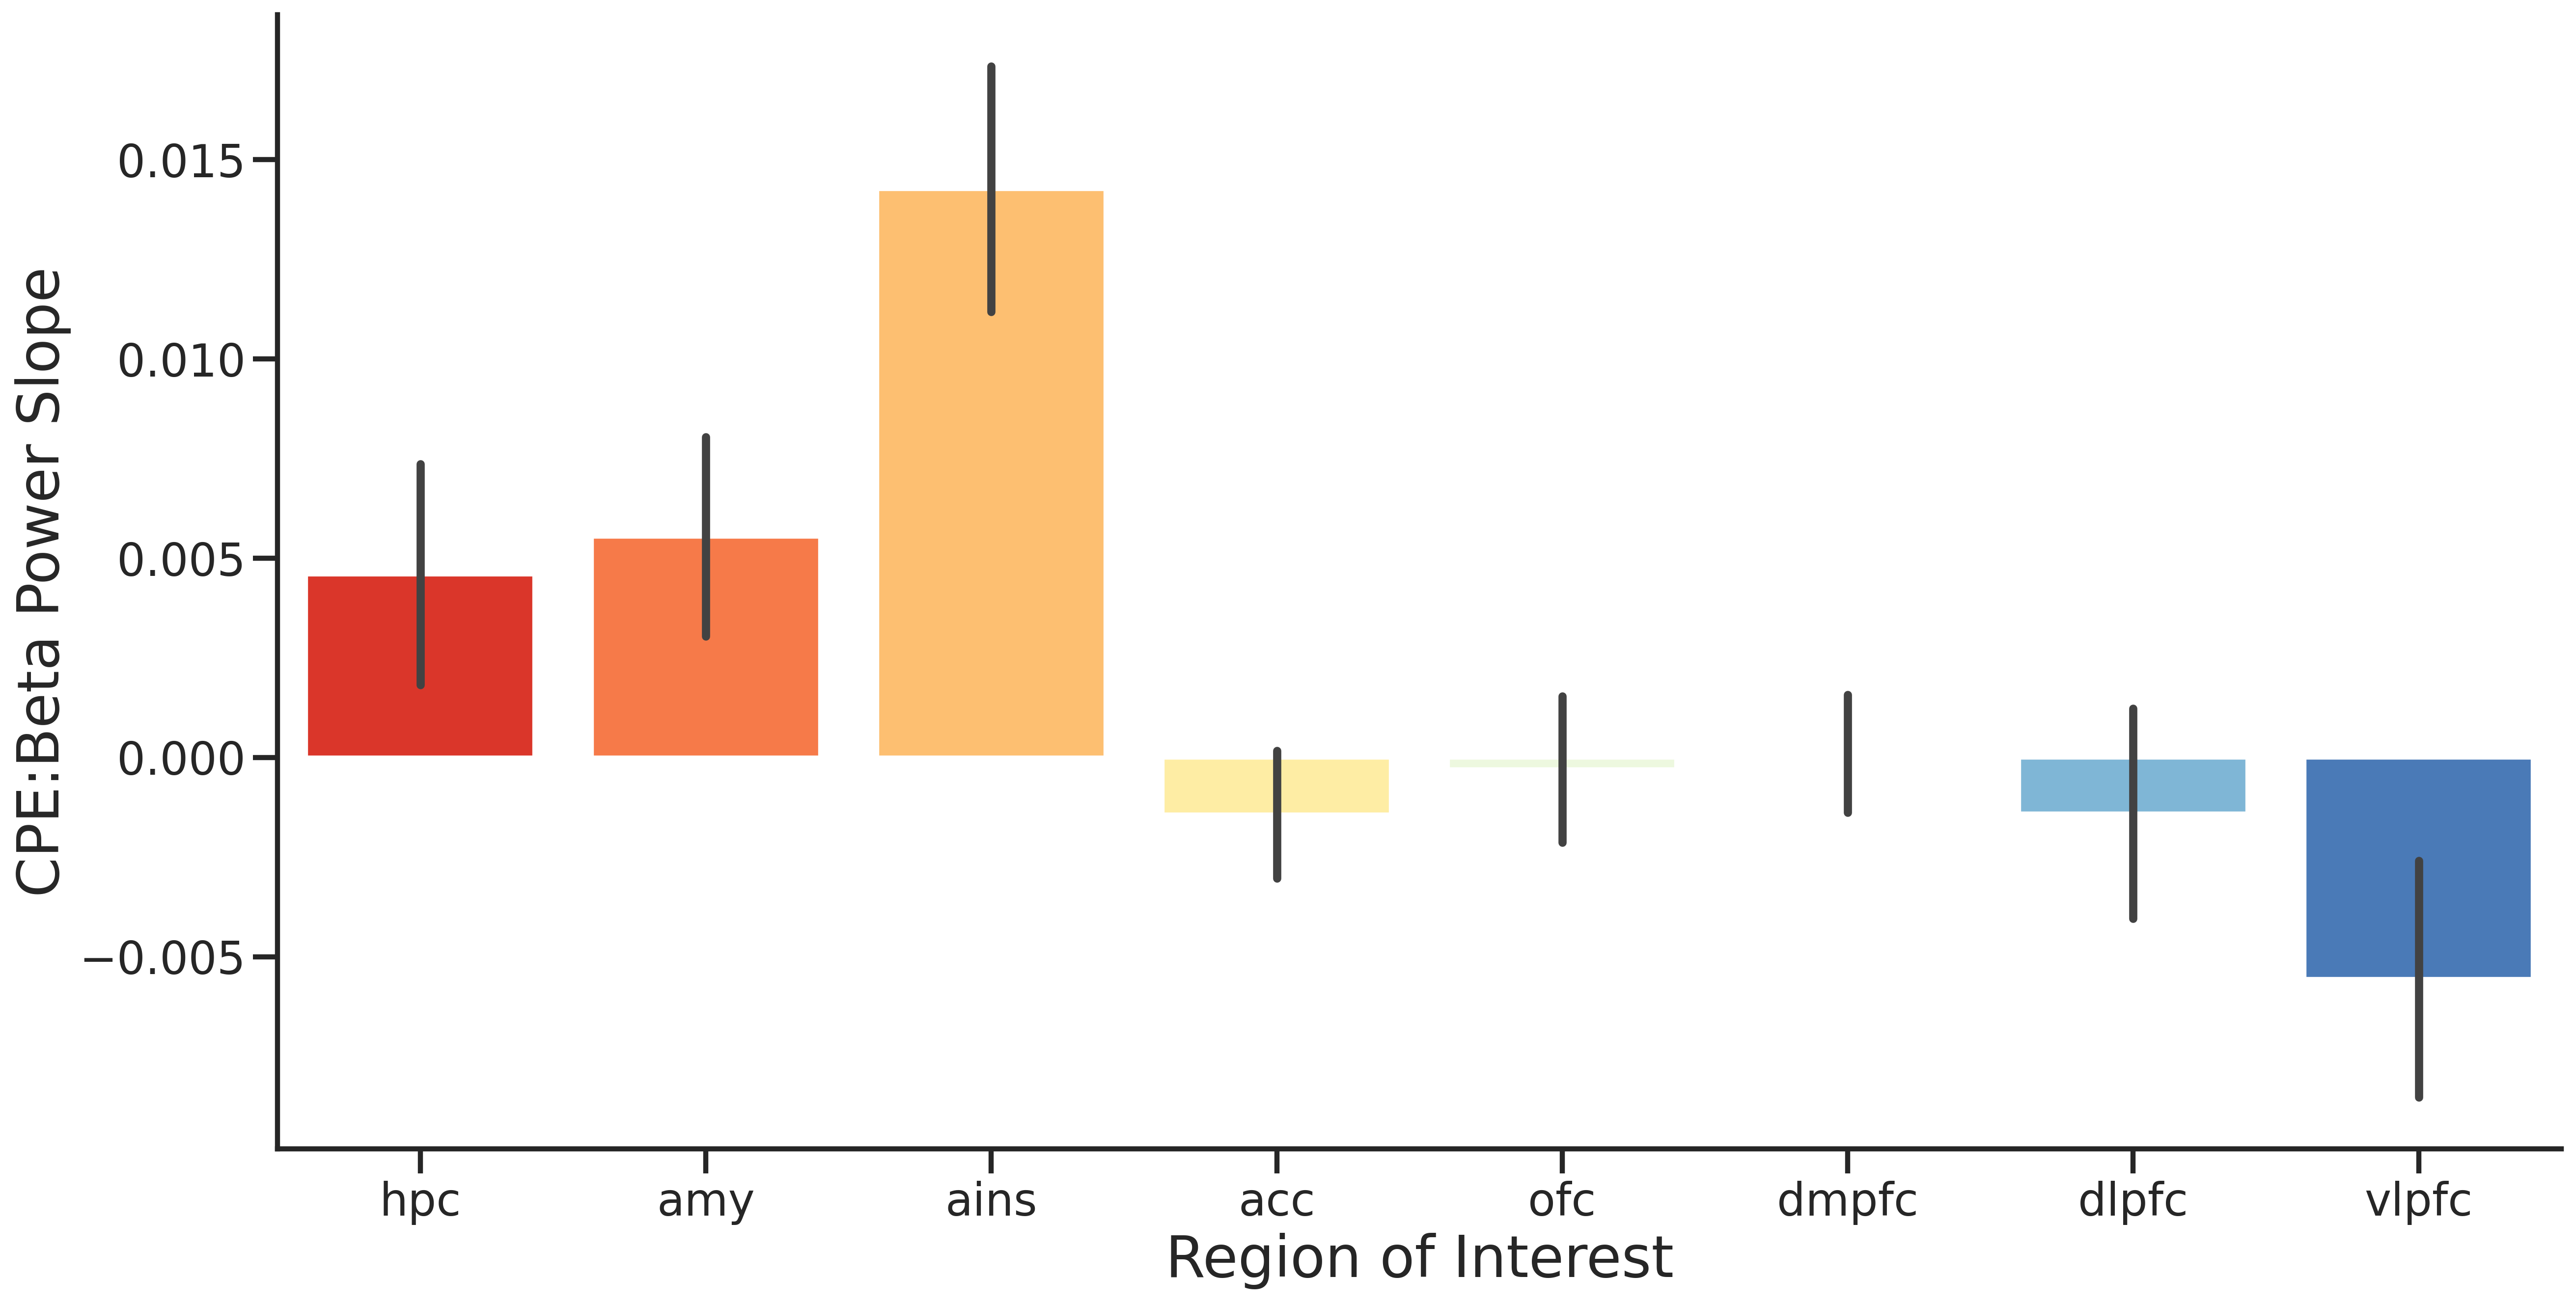

In [232]:

sns.set_theme(style='ticks') 
sns.set_context("poster")
# sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes, 
            palette = 'RdYlBu',
            saturation = 1,
            order=roi_list,
           errwidth=4,
           errorbar='se')

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Power Slope',fontsize=28,x=0.1)
plt.xlabel('Region of Interest',fontsize=28,y=-0.03)
sns.despine()

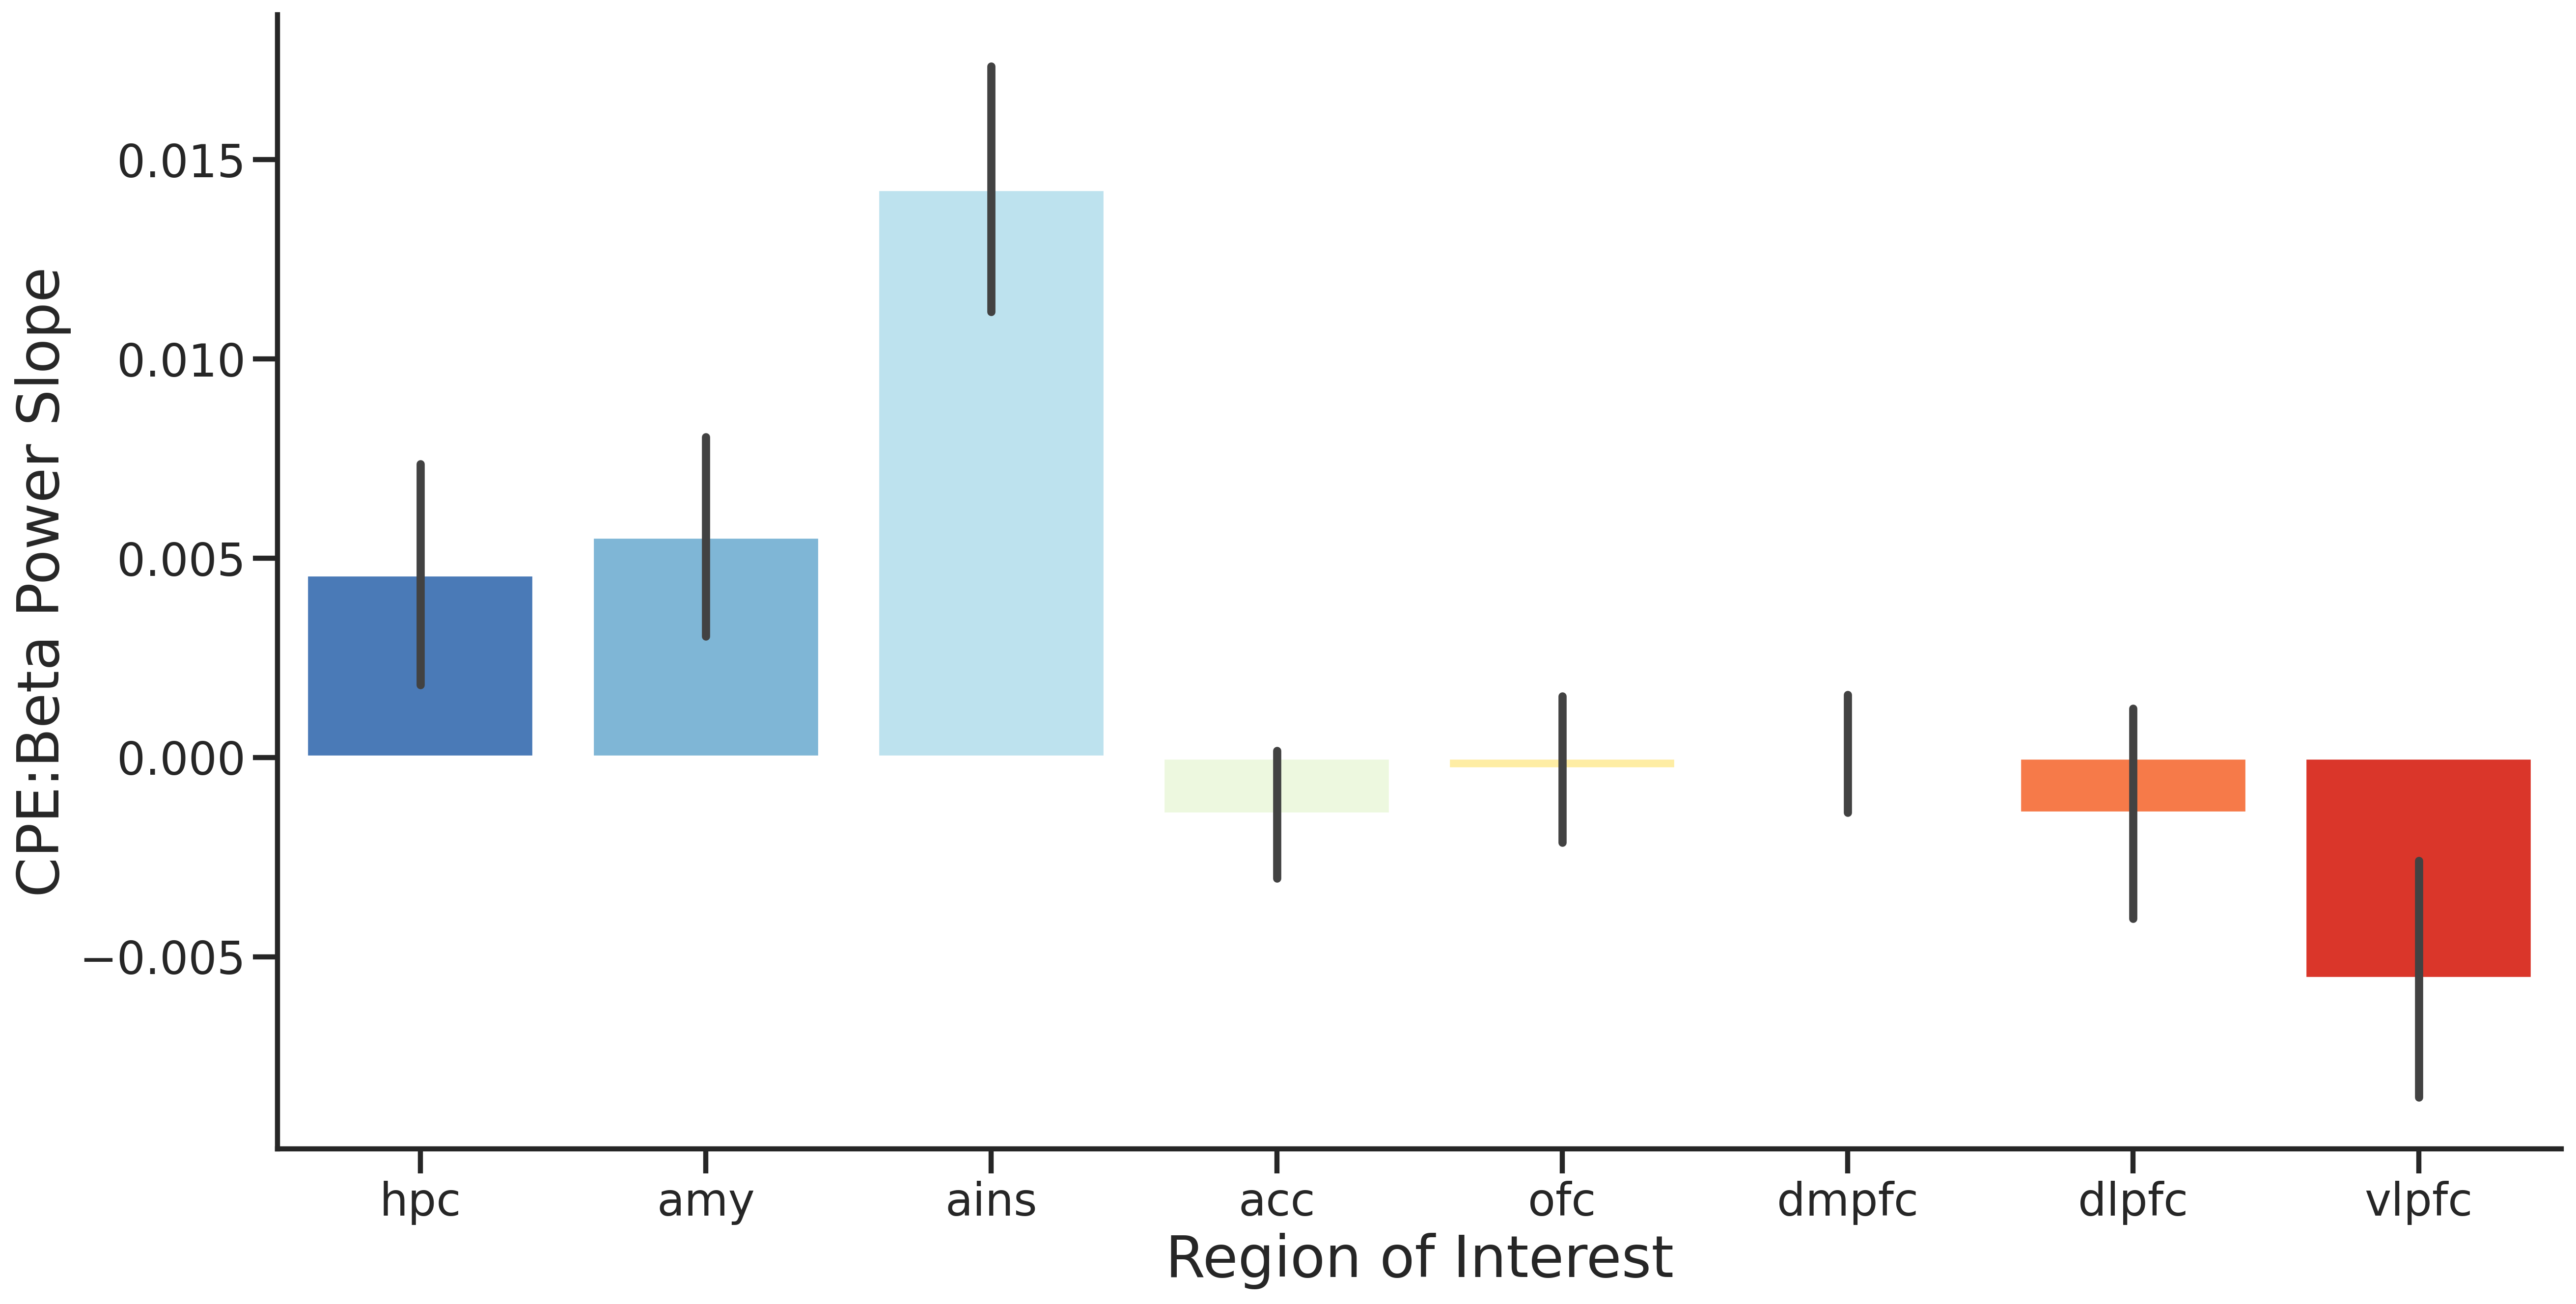

In [233]:
sns.set_theme(style='ticks') 
sns.set_context("poster")
# sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes, 
            palette = 'RdYlBu_r',
            order = roi_list,
            saturation = 1,
           errwidth=4,
           errorbar='se')

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Power Slope',fontsize=28,x=0.1)
plt.xlabel('Region of Interest',fontsize=28,y=-0.03)
sns.despine()

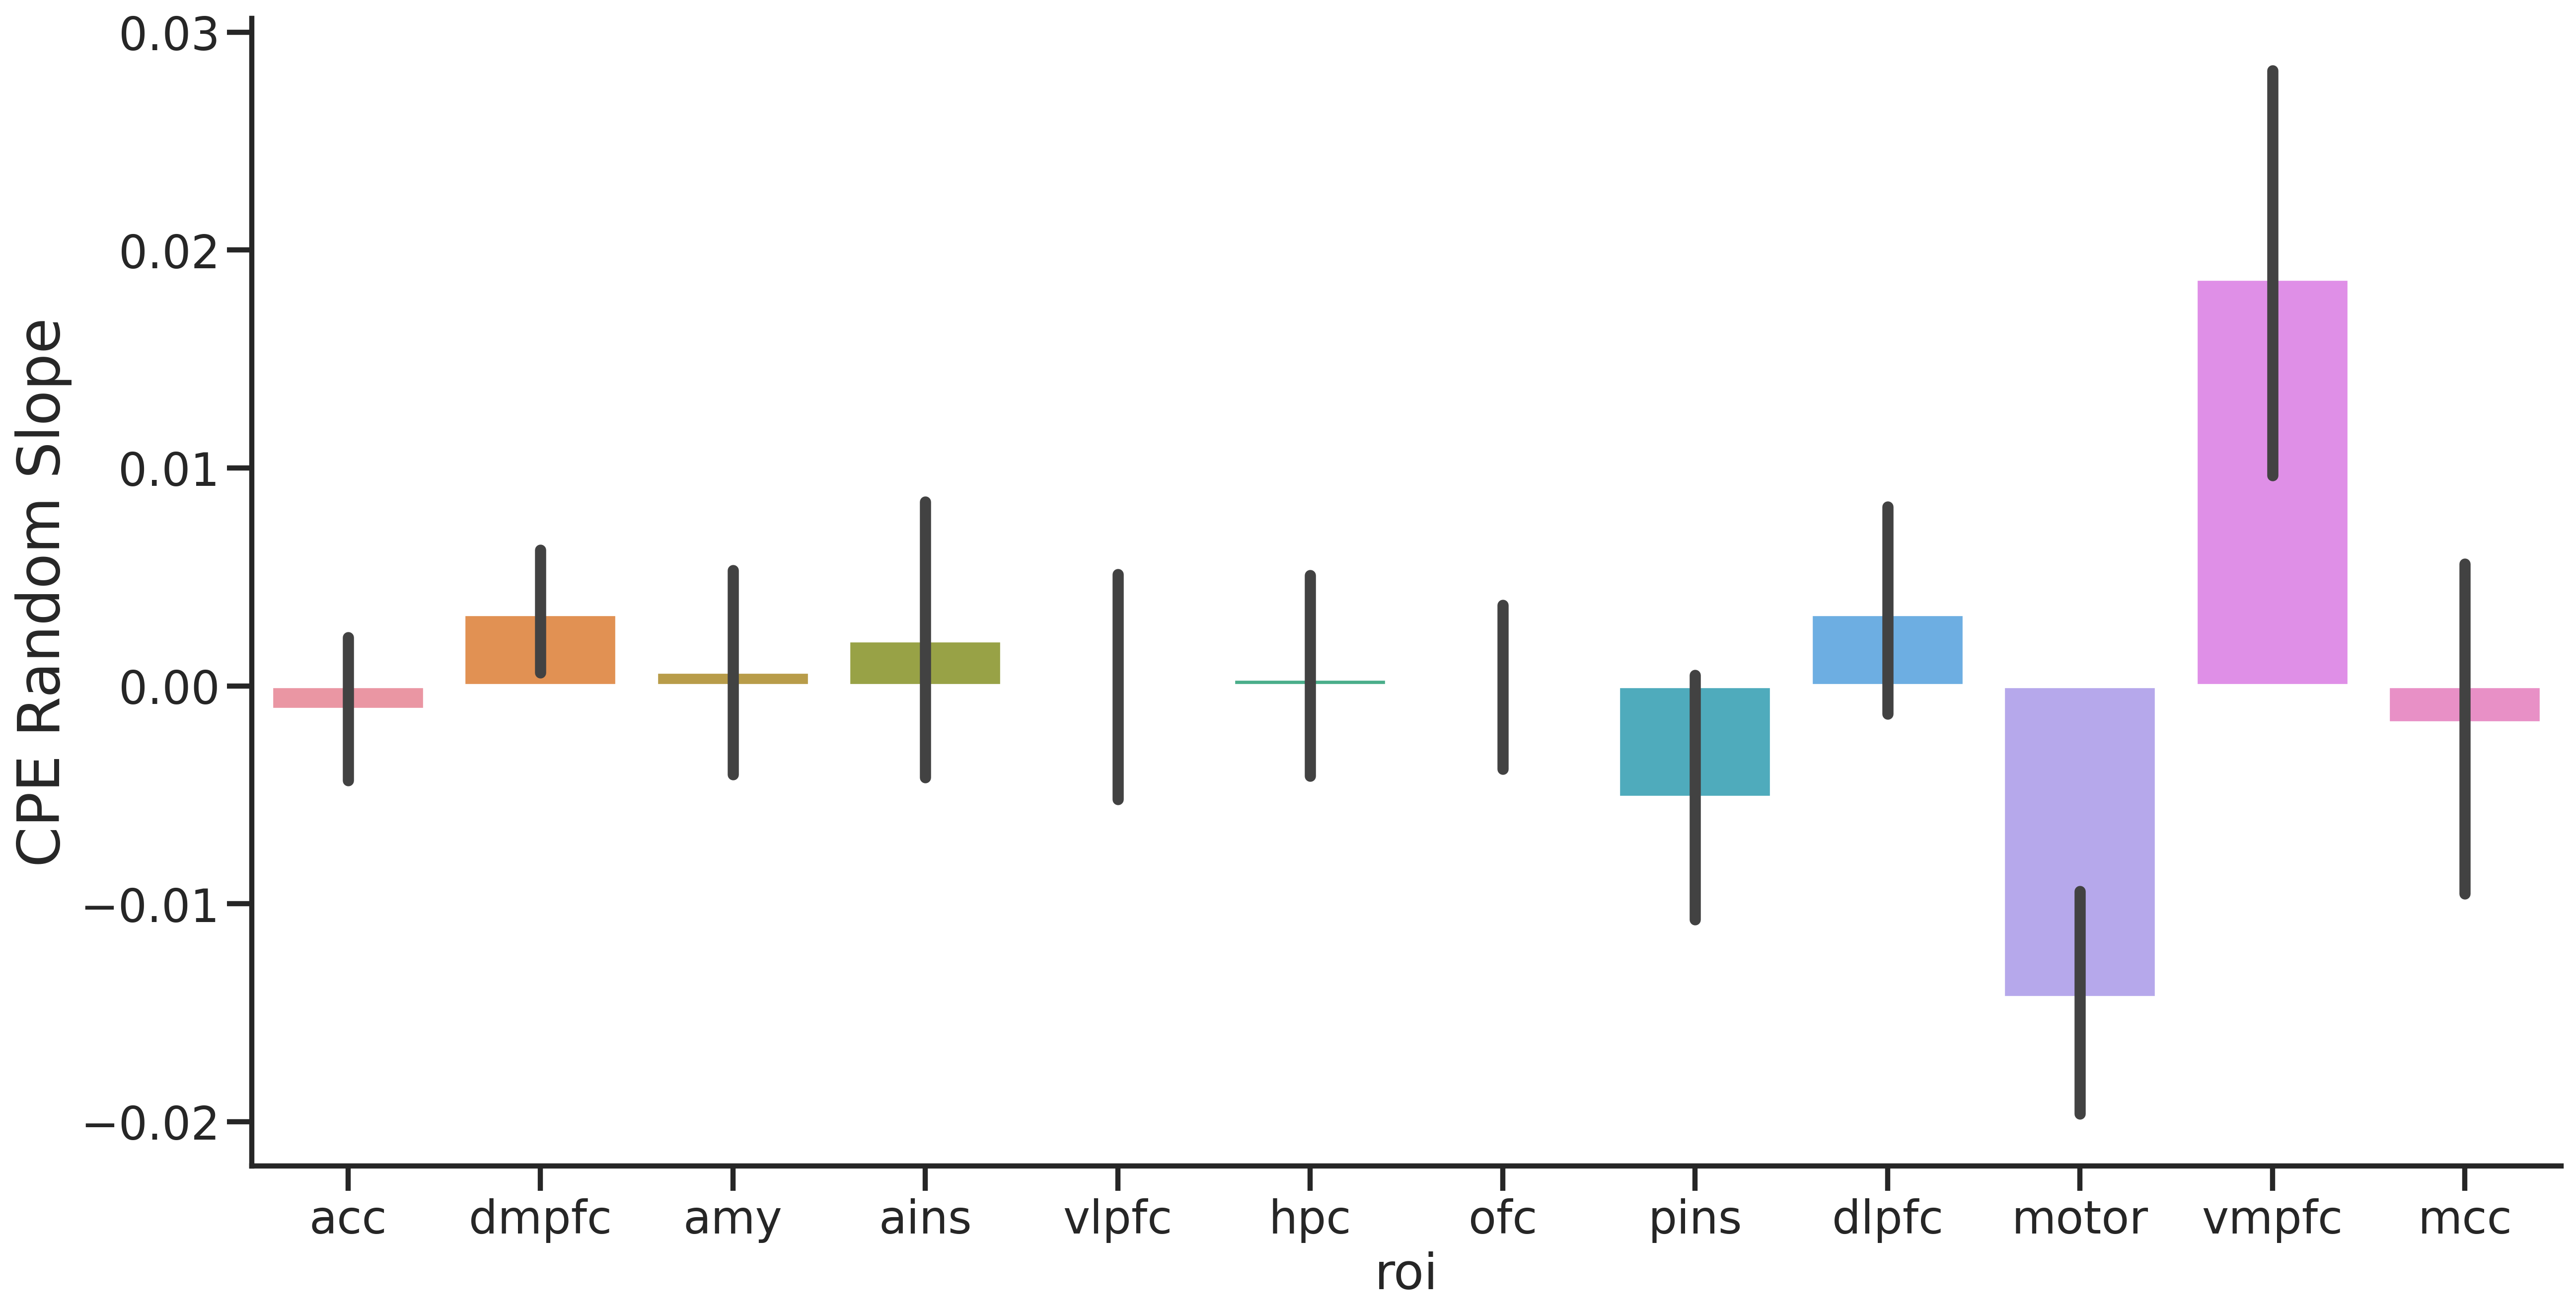

In [42]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,
              x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_slopes)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE Random Slope',fontsize=28,x=0.1)
# plt.xlabel('Region',fontsize=28,y=-0.03)
sns.despine()

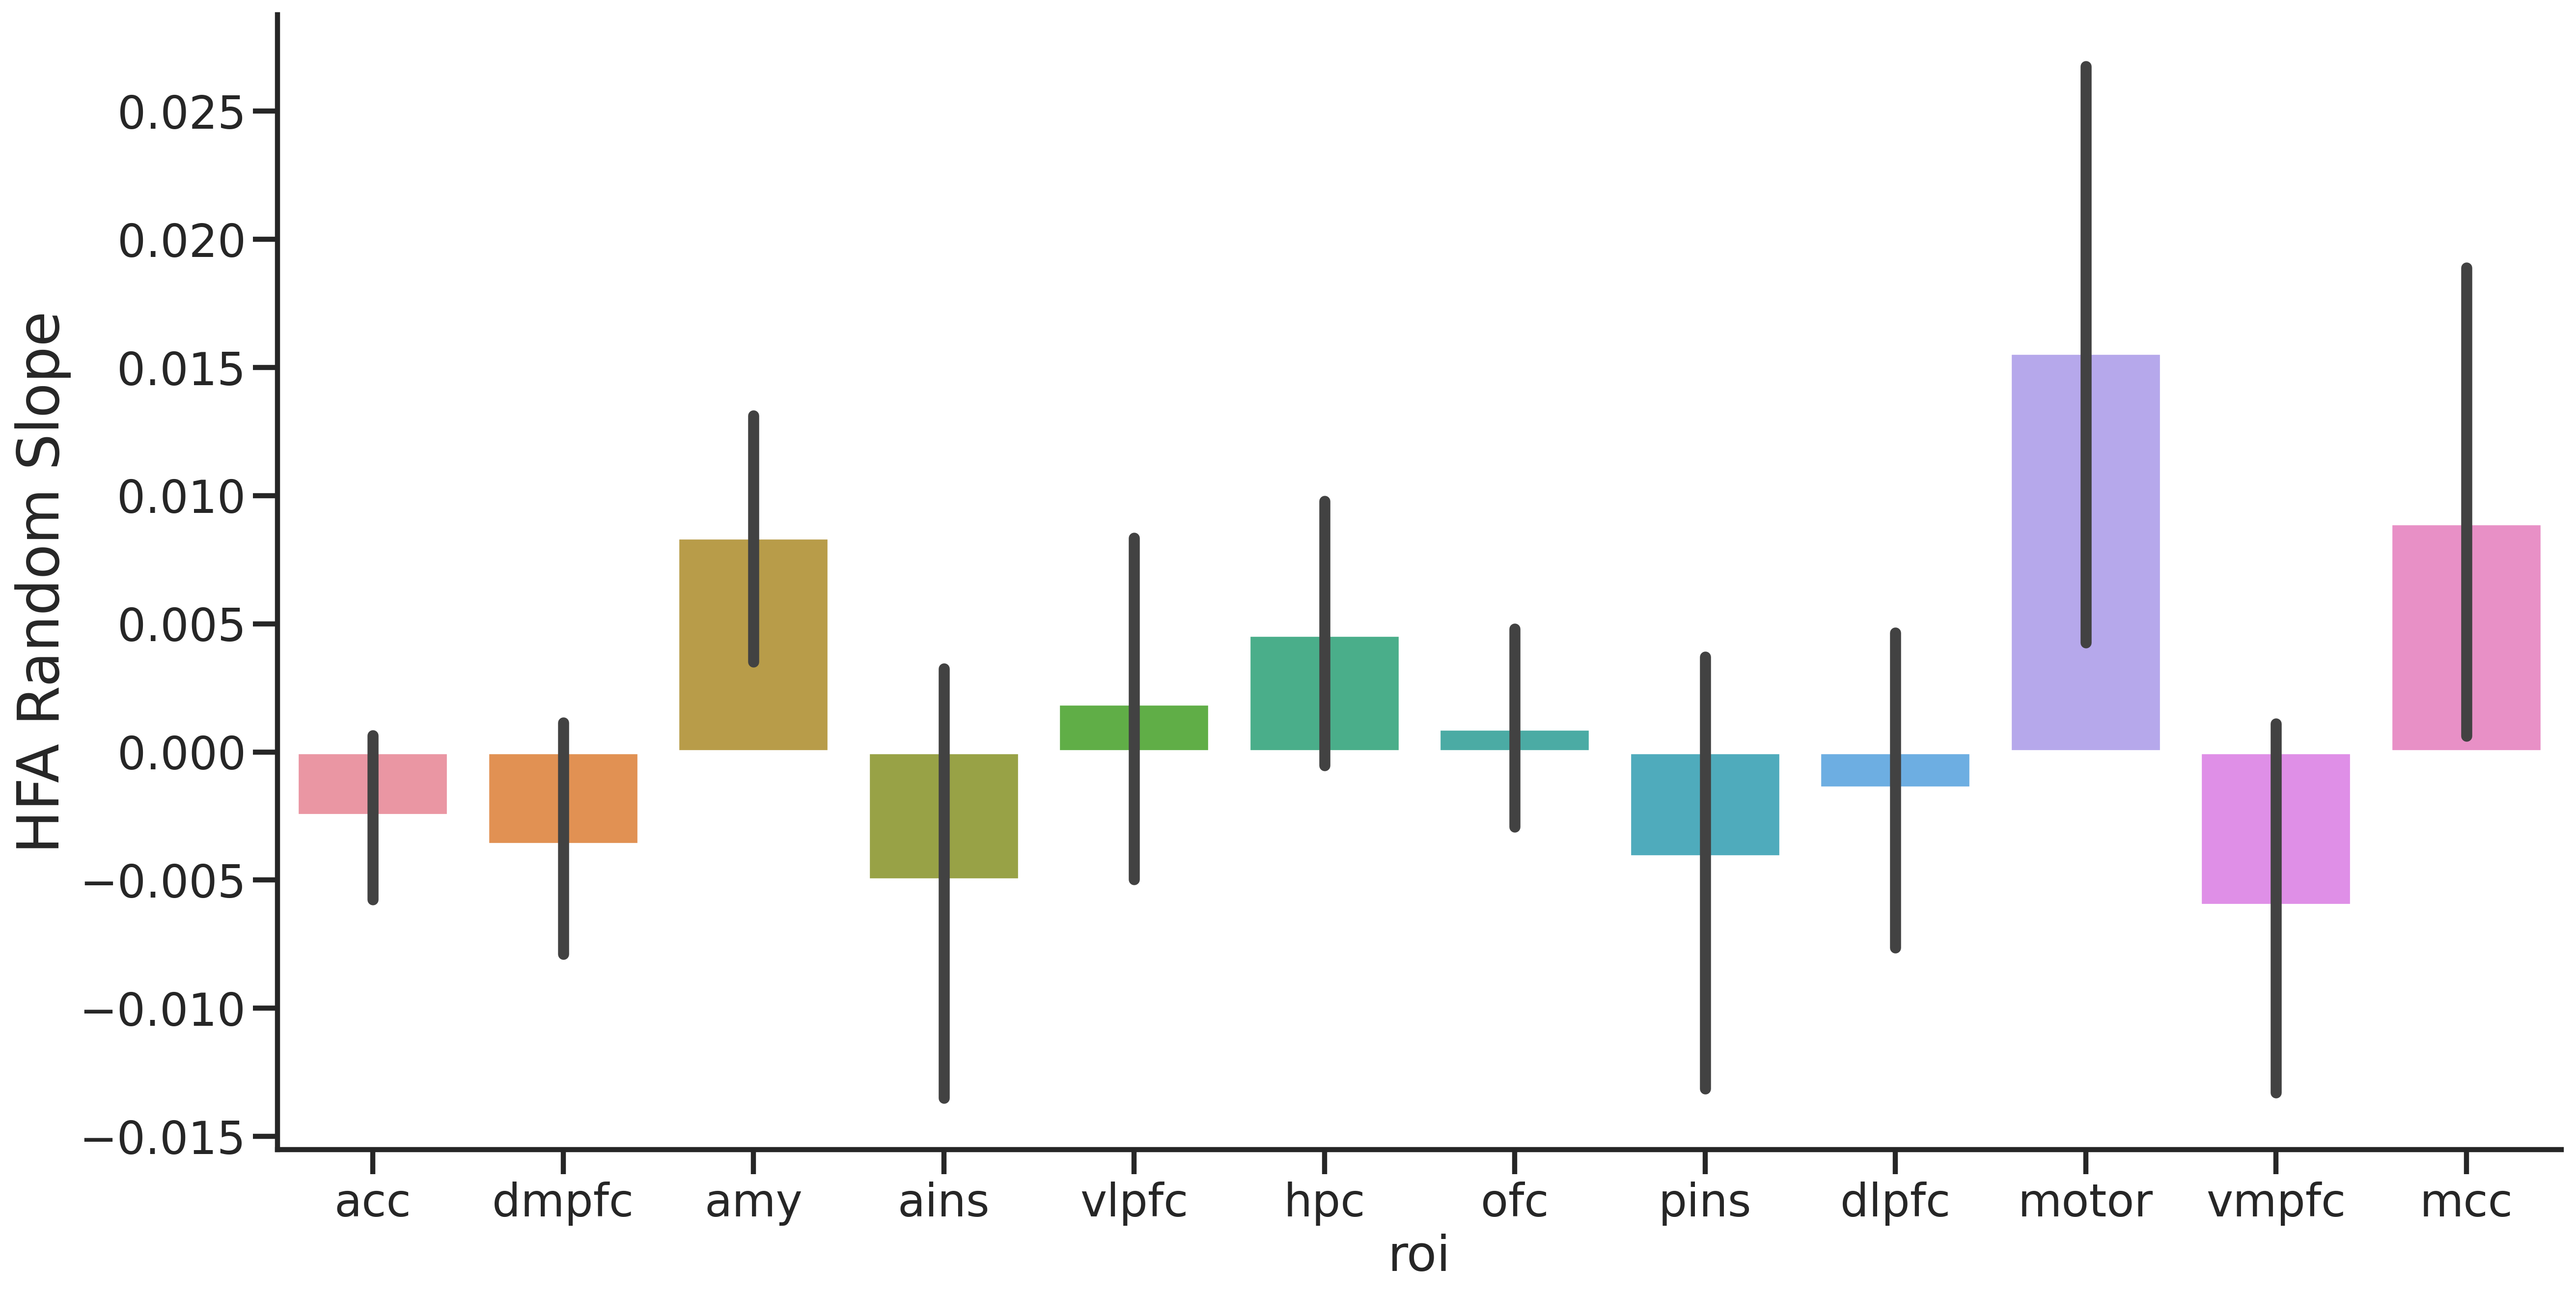

In [44]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,
              x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_beta_slopes)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('HFA Random Slope',fontsize=28,x=0.1)
# plt.xlabel('Region',fontsize=28,y=-0.03)
sns.despine()

In [450]:
subj_means_plot = rt_cpe_hfa_plot.groupby('subj_id').agg('mean')

In [451]:
subj_means_plot

,rand_intercepts,rand_cpe_slopes,rand_hfa_slopes,rand_cpe_hfa_slopes
subj_id,,,,
MS002,-0.276472,-0.011604,0.102205,0.033682
MS003,0.132748,-0.000141,-0.088724,0.002908
MS004,-0.169151,0.010888,0.120725,0.017341
MS009,-0.117387,-0.020632,0.103697,0.011781
MS011,0.184542,-0.028560,-0.024651,0.051579
MS015,0.098363,-0.005786,-0.157425,0.027323
MS016,0.439091,0.017121,-0.016099,0.032696
MS017,0.084068,-0.003172,0.007178,0.026329
MS019,-0.115148,0.014453,0.098954,-0.010265


In [83]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
# list(zip(subj_ids,bdi_list))
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df


,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS004,7
3,MS009,16
4,MS011,13
5,MS015,26
6,MS016,10
7,MS017,26
8,MS019,12
9,MS022,10


# Test encoding by ROI

In [46]:
##### define subset of ROIs to test 
roi_list = ['acc', 'dmpfc', 'amy', 'sts', 'ains', 'vlpfc', 'hpc', 'ofc',
       'pins', 'dlpfc', 'motor', 'vmpfc', 'mcc', 'phg']

In [45]:
var_list = ['decisionCPE']
outcome_var  = 'beta_pow'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'ains')]
ains_beta_model_fit = run_multi_hfa_model(region_df,var_list,outcome_var,rand_eff_var)
print(ains_beta_model_fit.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   beta_pow  
No. Observations:     6667      Method:               REML      
No. Groups:           50        Scale:                0.3240    
Min. group size:      92        Log-Likelihood:       -5817.6867
Max. group size:      147       Converged:            Yes       
Mean group size:      133.3                                     
----------------------------------------------------------------
                        Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept               0.218    0.028 7.687 0.000  0.163  0.274
decisionCPE             0.052    0.017 3.073 0.002  0.019  0.084
Group Var               0.038    0.014                          
Group x decisionCPE Cov 0.011    0.007                          
decisionCPE Var         0.012    0.005                          



In [65]:

var_list = ['C(GambleChoice)','GambleEV','decisionCPE']
###### TEST CPE ENCODING IN BETA POWER FIRST 
# var_list = ['decisionCPE']
outcome_var  = 'beta_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = run_multi_hfa_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:4]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc', [0.058947848536473606, 0.7042707422037724, 0.687026366398588]),
 ('dmpfc', [0.6639860667713506, 0.10386581205443647, 0.5879514200623693]),
 ('amy', [0.47934175924244893, 0.8778024853608332, 0.9968242483589116]),
 ('sts', [0.0002427346646288541, 0.8971206869285705, 0.7940244767615214]),
 ('ains',
  [0.0042892483733123245, 0.006219981183799125, 0.0009899559726333023]),
 ('vlpfc', [0.005888356946219961, 0.27771461068296643, 0.0005440634420595888]),
 ('hpc', [0.42000053823402395, 0.3850901214178728, 0.5624466300831148]),
 ('ofc', [0.2937800999291442, 0.44360852588217226, 0.0816889787314031]),
 ('pins', [0.14201667522849482, 0.40189575060865756, 0.005288542584151297]),
 ('dlpfc', [0.012631130328376618, 0.7892692443309617, 0.8649153820649769]),
 ('motor', [0.9616741625632356, 0.9146064337176734, 0.012647486570735793]),
 ('vmpfc', [0.5572069038780222, 0.9370470080234597, 0.17875050051968866]),
 ('mcc', [0.22086943537855952, 0.4047540403069284, 0.09802966697701633]),
 ('phg', [0.67624

In [52]:
###### TEST CPE ENCODING IN BETA POWER FIRST 
var_list = ['decisionCPE']
outcome_var  = 'beta_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = run_multi_hfa_model(region_df,var_list,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:2]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc', [0.6086706641451173]),
 ('dmpfc', [0.41699259025751945]),
 ('amy', [0.9924419119273828]),
 ('sts', [0.7696602035617524]),
 ('ains', [0.002116725730626363]),
 ('vlpfc', [0.0016982744031631954]),
 ('hpc', [0.5827833503890689]),
 ('ofc', [0.056935156834389586]),
 ('pins', [0.0013600729043798119]),
 ('dlpfc', [0.9700918177732575]),
 ('motor', [0.005483785117417851]),
 ('vmpfc', [0.17743878184801276]),
 ('mcc', [0.031430073263949525]),
 ('phg', [0.40888388607607773])]

In [70]:
###### define vars for model
roi_vars = ['C(GambleChoice)','GambleEV','TotalProfit','decisionCPE','beta_pow','decisionCPE:beta_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:7]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc',
  [0.0008343331734949907,
   0.00048755329979439834,
   0.039654386239434763,
   1.5384142903658587e-07,
   0.0373145939174766,
   0.9735887325284087]),
 ('dmpfc',
  [7.9627981384989e-08,
   4.0951830175963755e-11,
   0.20540882241424696,
   6.431709838796513e-11,
   0.0021815802252724698,
   0.6765780827099457]),
 ('amy',
  [0.002828996816157533,
   0.0006935633807366484,
   0.9775792991634306,
   2.3938136641344977e-06,
   nan,
   0.001599352885164095]),
 ('sts',
  [0.31313207465948745,
   0.5659442718717231,
   0.5953416944323233,
   0.46994893461210985,
   0.08828372146353565,
   0.2461390116659411]),
 ('ains',
  [0.0012773868788957246,
   0.00026488501598592306,
   0.7168560218092991,
   0.006454635467592171,
   0.04093291468036069,
   0.04961919146107943]),
 ('vlpfc',
  [0.06320736294005413,
   5.061404149597938e-08,
   0.004037228166491683,
   0.003981418218148898,
   0.6006894595019143,
   0.026701397910547955]),
 ('hpc',
  [0.049737250283827444,
   0.01644297129307409

In [72]:
###### define vars for model
roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','beta_pow','decisionCPE:beta_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:6]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc',
  [0.0003446679816124444,
   8.749860387883428e-05,
   1.543139872940356e-07,
   0.0046344240205791025,
   0.7603545814486545]),
 ('dmpfc',
  [7.975346802840452e-09,
   1.0086492624866323e-13,
   1.3802579355848584e-13,
   9.648815281411107e-05,
   0.986090280478038]),
 ('amy',
  [0.005773124084060656,
   6.253792118515583e-05,
   3.942066994868294e-05,
   nan,
   0.00047452952662126733]),
 ('sts',
  [0.0013213839352624452,
   9.13993736358363e-07,
   3.3837614548345977e-05,
   2.671312141692233e-05,
   0.32152663825579264]),
 ('ains',
  [0.0002331918378272409,
   6.053569730833811e-05,
   0.0010935989976125307,
   0.002491415763638641,
   0.017643423533830485]),
 ('vlpfc',
  [0.04032924447055448,
   1.3641370348965354e-08,
   nan,
   0.17566399228274143,
   nan]),
 ('hpc',
  [0.019678466719979366,
   0.00364396300941392,
   0.0006095259427307619,
   0.23146968279120295,
   0.2358576797758607]),
 ('ofc',
  [0.005777756041689316,
   1.2501293821222865e-05,
   1.9002576406435198

In [53]:
###### define vars for model
roi_vars = ['decisionCPE','beta_pow','decisionCPE:beta_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = beta_reg_df[(beta_reg_df.roi == roi)]
    roi_fit = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:4]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc', [0.017068273787186533, 0.0008463051238226337, 0.7883543599182797]),
 ('dmpfc', [7.383759410744714e-19, 3.476120835430061e-05, 0.6792062406317162]),
 ('amy', [0.15115399096273635, 0.6369348421482299, 0.682312350778834]),
 ('sts', [0.16815177416999394, 6.640682175602312e-07, 0.09544313530459884]),
 ('ains', [0.0005062295437816929, nan, 2.6409308356077636e-06]),
 ('vlpfc', [0.27949602246108873, 0.05201551524195677, 0.15692427118326974]),
 ('hpc', [0.0017256488700988367, 0.02311320635058364, 0.25173805309623787]),
 ('ofc', [0.0029835079223497593, 0.05932396246121901, 0.7681950170007692]),
 ('pins', [0.8947940383513344, 0.54989103929062, 0.5508874119768048]),
 ('dlpfc', [0.660946919886312, 0.1226205070360167, 0.7804018653930678]),
 ('motor', [0.8918179853398203, 0.6582628926450497, 0.5939517742071576]),
 ('vmpfc', [4.0467098734975215e-07, 0.09927572645880431, 0.43163624770557507]),
 ('mcc', [0.08237619997946709, 0.739039274135934, 0.40288428567662626]),
 ('phg', [0.0022468721967449

In [68]:
roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','beta_pow','decisionCPE:beta_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'amy')]
roi_fit = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
print(roi_fit.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            logRT_t1  
No. Observations:             11029              Method:                        REML      
No. Groups:                   84                 Scale:                         0.1272    
Min. group size:              94                 Log-Likelihood:                -4522.2063
Max. group size:              146                Converged:                     Yes       
Mean group size:              131.3                                                       
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        1.027    0.027 38.461 0.000  0.975  1.079
C(GambleChoice)[T.2]      

In [69]:
roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','beta_pow','decisionCPE:beta_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'ains')]
roi_fit = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
print(roi_fit.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            logRT_t1  
No. Observations:             6618               Method:                        REML      
No. Groups:                   50                 Scale:                         0.1426    
Min. group size:              91                 Log-Likelihood:                -3069.6008
Max. group size:              146                Converged:                     Yes       
Mean group size:              132.4                                                       
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.945    0.022 42.774 0.000  0.901  0.988
C(GambleChoice)[T.2]      

In [505]:
roi_vars = ['decisionCPE','beta_pow','decisionCPE:beta_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'ains')]
roi_fit = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
print(roi_fit.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1  
No. Observations:          6618            Method:                     REML      
No. Groups:                50              Scale:                      0.1445    
Min. group size:           91              Log-Likelihood:             -3093.4469
Max. group size:           146             Converged:                  No        
Mean group size:           132.4                                                 
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.928    0.022 42.016 0.000  0.885  0.972
decisionCPE                             0.019    0.005  3.477 0.001  0.008  0.029
beta_pow                              

In [107]:

roi_vars = ['C(GambleChoice)','GambleEV','decisionCPE','beta_pow','decisionCPE:beta_pow']
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
region_df = beta_reg_df[(beta_reg_df.roi == 'amy')]
roi_fit = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
print(roi_fit.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            logRT_t1  
No. Observations:             11029              Method:                        REML      
No. Groups:                   84                 Scale:                         0.1272    
Min. group size:              94                 Log-Likelihood:                -4522.2063
Max. group size:              146                Converged:                     Yes       
Mean group size:              131.3                                                       
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        1.027    0.027 38.461 0.000  0.975  1.079
C(GambleChoice)[T.2]      

In [108]:
# ains_cpe_beta = [val['decisionCPE:beta_pow'] for val in roi_fit.random_effects.values()]
ains_cpe = [val['decisionCPE'] for val in roi_fit.random_effects.values()]
ains_beta_pow = [val['beta_pow'] for val in roi_fit.random_effects.values()]
ains_cpe_beta = [val['decisionCPE:beta_pow'] for val in roi_fit.random_effects.values()]

In [111]:
ains_beta_results = pd.DataFrame({'unique_reref_ch':list(roi_fit.random_effects.keys()),
                                     'ains_cpe':ains_cpe,
                                     'ains_beta_pow':ains_beta_pow,
                                  'ains_cpe_beta':ains_cpe_beta})
ains_beta_results

,unique_reref_ch,ains_cpe,ains_beta_pow,ains_cpe_beta
0,MS002_lagit1-lagit2,0.011131,0.013782,0.029393
1,MS002_lagit2-lagit3,0.002699,0.017813,0.032967
2,MS002_lagit3-lagit4,0.011150,0.014576,0.032255
3,MS002_ragit1-ragit2,0.011514,0.013517,0.030358
4,MS002_ragit2-ragit3,0.010600,0.013804,0.029227
...,...,...,...,...
79,MS043_laglt2-laglt3,0.004802,0.015927,0.024978
80,MS043_laglt3-laglt4,0.008214,0.011754,0.014644
81,MS043_laglt4-laglt5,0.001605,0.014830,0.015910
82,MS043_raglt3-raglt4,0.003737,0.012254,0.007544


In [112]:
### sort slopes by ROI
unique_roi_label = []
subj_id_label    = []

for ch in ains_beta_results.unique_reref_ch:
    unique_roi = beta_reg_df.roi[beta_reg_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    subj_id = beta_reg_df.subj_id[beta_reg_df.unique_reref_ch==ch].unique().item()
    subj_id_label.append(subj_id)
    
ains_beta_results['roi'] = unique_roi_label
ains_beta_results['subj_id'] = subj_id_label
ains_beta_results

,unique_reref_ch,ains_cpe,ains_beta_pow,ains_cpe_beta,roi,subj_id
0,MS002_lagit1-lagit2,0.011131,0.013782,0.029393,amy,MS002
1,MS002_lagit2-lagit3,0.002699,0.017813,0.032967,amy,MS002
2,MS002_lagit3-lagit4,0.011150,0.014576,0.032255,amy,MS002
3,MS002_ragit1-ragit2,0.011514,0.013517,0.030358,amy,MS002
4,MS002_ragit2-ragit3,0.010600,0.013804,0.029227,amy,MS002
...,...,...,...,...,...,...
79,MS043_laglt2-laglt3,0.004802,0.015927,0.024978,amy,MS043
80,MS043_laglt3-laglt4,0.008214,0.011754,0.014644,amy,MS043
81,MS043_laglt4-laglt5,0.001605,0.014830,0.015910,amy,MS043
82,MS043_raglt3-raglt4,0.003737,0.012254,0.007544,amy,MS043


In [113]:
subj_means_plot = ains_beta_results.groupby('subj_id').agg('mean')
subj_means_plot

,ains_cpe,ains_beta_pow,ains_cpe_beta
subj_id,,,
MS002,0.009424,0.014180,0.028845
MS003,-0.009015,-0.004582,-0.010956
MS009,-0.015768,0.010137,0.005790
MS011,-0.027672,-0.001379,-0.012648
MS015,-0.013199,-0.001098,-0.006030
MS016,0.005751,-0.020832,-0.018081
MS017,-0.000545,-0.001019,0.007037
MS019,0.009139,-0.001153,-0.006822
MS022,-0.019920,-0.012294,-0.003584


In [114]:
len(subj_means_plot)

20

In [115]:
roi_subj = subj_means_plot.index.values.tolist()
roi_subj

['MS002',
 'MS003',
 'MS009',
 'MS011',
 'MS015',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS024',
 'MS025',
 'MS026',
 'MS027',
 'MS028',
 'MS029',
 'MS030',
 'MS033',
 'MS035',
 'MS041',
 'MS043']

In [116]:
roi_subj_bdi = subj_info_df.bdi[subj_info_df.subj_id.isin(roi_subj)].tolist()

In [119]:
r,p_r = pearsonr(roi_subj_bdi,subj_means_plot.ains_beta_pow.values)
print(p_r)

0.8185102280822656


In [118]:
subj_means_plot['bdi'] = roi_subj_bdi
subj_means_plot

,ains_cpe,ains_beta_pow,ains_cpe_beta,bdi
subj_id,,,,
MS002,0.009424,0.014180,0.028845,14
MS003,-0.009015,-0.004582,-0.010956,8
MS009,-0.015768,0.010137,0.005790,16
MS011,-0.027672,-0.001379,-0.012648,13
MS015,-0.013199,-0.001098,-0.006030,26
MS016,0.005751,-0.020832,-0.018081,10
MS017,-0.000545,-0.001019,0.007037,26
MS019,0.009139,-0.001153,-0.006822,12
MS022,-0.019920,-0.012294,-0.003584,10


In [120]:
high_bdi_cpe_beta = subj_means_plot['ains_beta_pow'][subj_means_plot['bdi']>=20]
low_bdi_cpe_beta = subj_means_plot['ains_beta_pow'][subj_means_plot['bdi']<20]
ttest_ind(low_bdi_cpe_beta,high_bdi_cpe_beta)

TtestResult(statistic=0.06483782667794376, pvalue=0.9490177902903542, df=18.0)

In [121]:
sm.OLS(endog=subj_means_plot.ains_beta_pow.values,exog=sm.add_constant(roi_subj_bdi)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.052
Method:                 Least Squares   F-statistic:                   0.05422
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.819
Time:                        17:45:50   Log-Likelihood:                 65.923
No. Observations:                  20   AIC:                            -127.8
Df Residuals:                      18   BIC:                            -125.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.005     -0.412      0.685      -0.012       0.008
x1          5.988e-05      0.000      0.233      0.819      -0.000       0.001
==============================================================================
Omnibus:                        0.072   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.964   Jarque-Bera (JB):                0.295
Skew:                          -0.049   Prob(JB):                        0.863
Kurtosis:                       2.413   Cond. No.                         44.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.30053044855551075 0.19792611809507793


Text(0, 0.5, 'CPE:Beta Power Rand Slope')

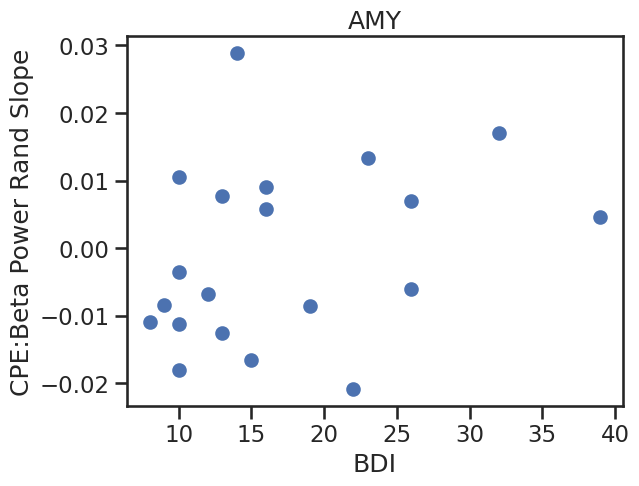

In [125]:
sns.set_context('talk')
r,p_r = pearsonr(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
print(r,p_r)
plt.figure()
plt.scatter(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
plt.title('AMY')
plt.xlabel('BDI')
plt.ylabel('CPE:Beta Power Rand Slope')

In [501]:
list(zip(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values))

[(14, 0.014073753428344486),
 (8, -0.023881216963066335),
 (16, -0.00261742544941908),
 (26, -0.0222769831702146),
 (26, -0.014078973030099489),
 (16, 0.011991609030255677),
 (13, 0.015075412267724159),
 (32, 0.015227517352320233),
 (19, -0.024152111297686695),
 (15, -0.03482032045411541),
 (10, 0.002791211481728208)]

0.03723097358511451 0.9134585283837746


Text(0, 0.5, 'CPE:Beta Power Rand Slope')

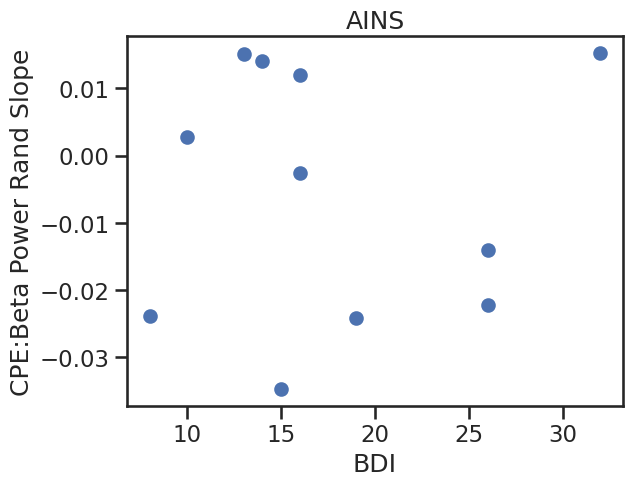

In [504]:
sns.set_context('talk')
r,p_r = pearsonr(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
print(r,p_r)
plt.figure()
plt.scatter(roi_subj_bdi,subj_means_plot.ains_cpe_beta.values)
plt.title('AINS')
plt.xlabel('BDI')
plt.ylabel('CPE:Beta Power Rand Slope')


In [ ]:
rt_cpe_beta_plot = rt_cpe_beta_results.copy()
# good_roi = full_hfa_model_results['roi'].value_counts().index[full_hfa_model_results['roi'].value_counts()>20].to_list()
rt_cpe_beta_plot = rt_cpe_beta_plot[rt_cpe_beta_plot.roi.isin(roi_list)]
rt_cpe_beta_plot


In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 10),dpi=300)

sns.barplot(data = rt_cpe_beta_plot,
              x = rt_cpe_beta_plot.roi, y = rt_cpe_beta_plot.rand_cpe_beta_slopes)

# ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE:Beta Random Slope',fontsize=28,x=0.1)
# plt.xlabel('Region',fontsize=28,y=-0.03)
sns.despine()

In [453]:
pearsonr(subj_info_df.bdi,subj_means_plot.rand_cpe_hfa_slopes)

PearsonRResult(statistic=-0.687140730586925, pvalue=0.0005790675395670582)

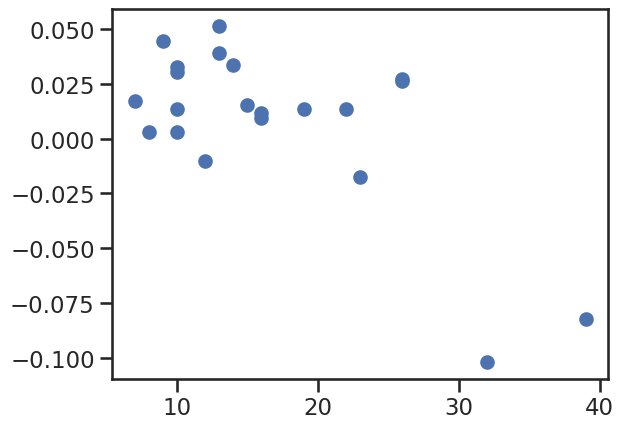

In [454]:
sns.set_context('talk')
plt.scatter(subj_info_df.bdi,subj_means_plot.rand_cpe_hfa_slopes)

In [455]:
roi_subj_means_plot = rt_cpe_hfa_plot.groupby(['subj_id','roi']).agg('mean')
roi_subj_means_plot

rand_intercepts  rand_cpe_slopes  rand_hfa_slopes  \
subj_id roi                                                        
MS002   acc          -0.271854        -0.010971         0.226184   
        ains         -0.276556        -0.010589         0.143936   
        amy          -0.279322        -0.013868         0.061896   
        dlpfc        -0.277818        -0.009575        -0.082667   
        dmpfc        -0.269651        -0.009219         0.167931   
...                        ...              ...              ...   
MS043   dlpfc        -0.319307         0.004699        -0.013602   
        dmpfc        -0.318911         0.008299        -0.005774   
        hpc          -0.316983         0.004862        -0.057422   
        ofc          -0.313151         0.010042         0.037051   
        vlpfc        -0.305838         0.007163         0.220411   

               rand_cpe_hfa_slopes  
subj_id roi                         
MS002   acc               0.087314  
        ains              0.103684  
        amy               0.055260  
        dlpfc             0.020116  
        dmpfc             0.034026  
...                            ...  
MS043   dlpfc            -0.066452  
        dmpfc             0.018956  
        hpc              -0.041143  
        ofc              -0.019569  
        vlpfc            -0.003896  

[183 rows x 4 columns]

In [456]:
# roi_subj_means_plot.index.values
# roi_subj_means_plot.index.get_level_values(level='roi').item
roi_subj_means_plot[roi_subj_means_plot.index.isin(['acc'],level=1)]

,,rand_intercepts,rand_cpe_slopes,rand_hfa_slopes,rand_cpe_hfa_slopes
subj_id,roi,,,,
MS002,acc,-0.271854,-0.010971,0.226184,0.087314
MS003,acc,0.134826,-0.000086,-0.095016,-0.012635
MS009,acc,-0.110866,-0.022762,0.092363,0.063159
MS011,acc,0.186445,-0.030934,0.034655,0.009793
MS015,acc,0.090295,-0.007514,-0.248294,0.086405
MS016,acc,0.440093,0.017934,0.003962,0.038183
MS017,acc,0.086501,-0.004378,0.001412,-0.048092
MS019,acc,-0.120063,0.014277,0.065628,-0.050909
MS022,acc,0.529629,-0.019055,0.056228,0.046272


In [457]:
roi_subj = roi_data.index.get_level_values(level='subj_id').values.tolist()
roi_subj_bdi = subj_info_df.bdi[subj_info_df.subj_id.isin(roi_subj)]
roi_subj_bdi 

2      7
4     13
5     26
8     12
9     10
16    19
17    39
Name: bdi, dtype: int64

acc -0.34762781904069395 0.13313991924252366
dmpfc -0.5182376264894748 0.016098132939839232
amy -0.30583551622918176 0.18973703275039056
ains 0.2406656564542303 0.4759316875050293
vlpfc -0.06855909320876796 0.7739582379522109
hpc -0.4708124094591278 0.04189699946027177
ofc -0.4341872035707192 0.06324644924381048
pins -0.4041935632586297 0.17074584245451044
dlpfc -0.22910719542383695 0.33123368705442224
motor -0.6466585253164127 0.08312558605171379
vmpfc -0.3383399655383184 0.5775784151017439
mcc -0.6532423264402885 0.11160416323526802


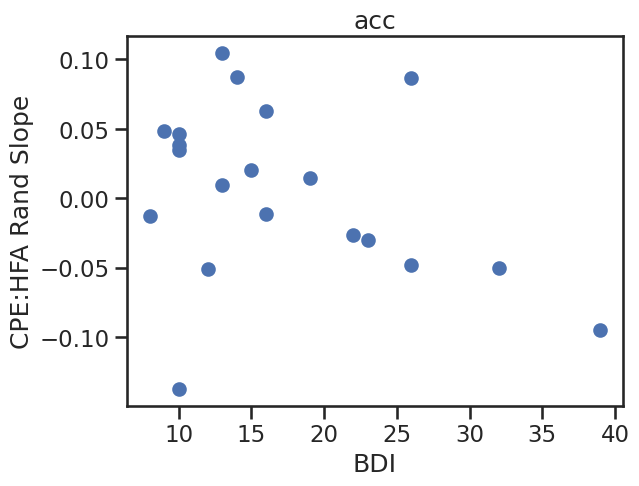

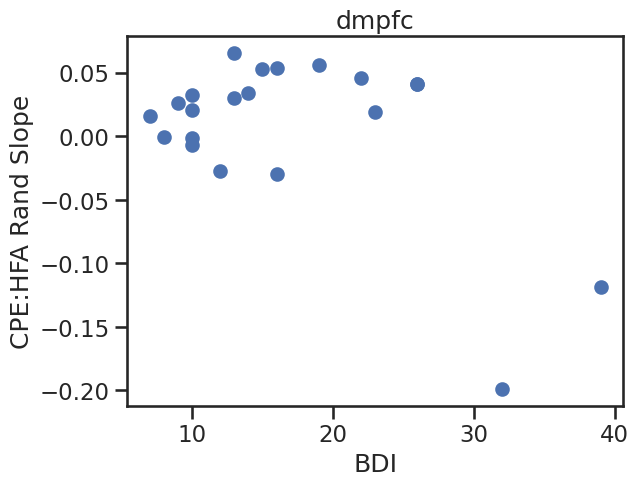

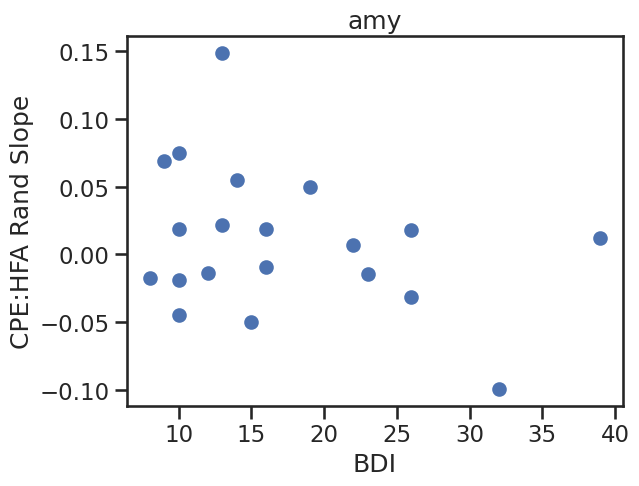

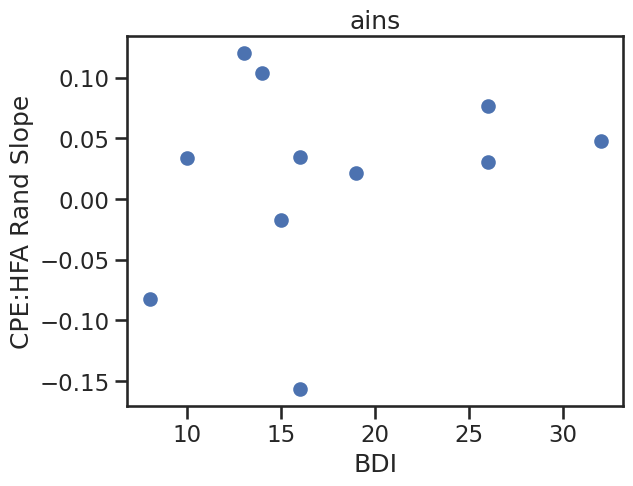

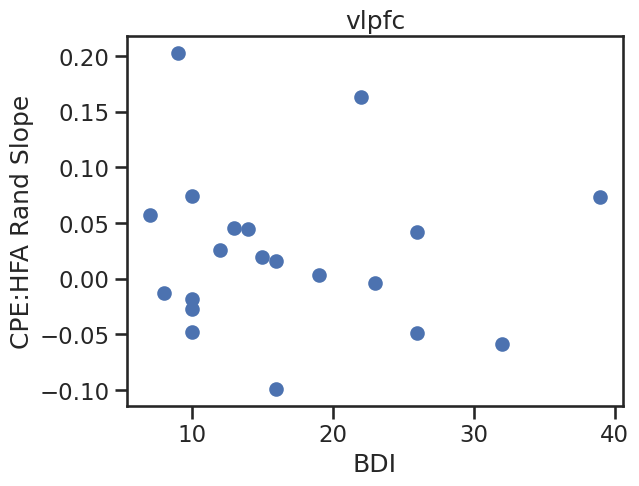

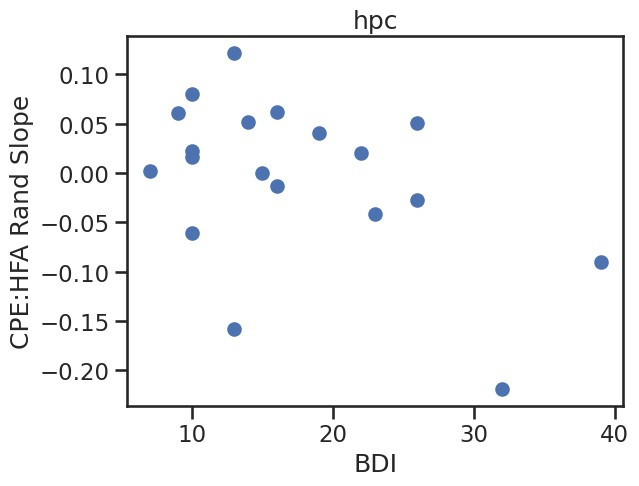

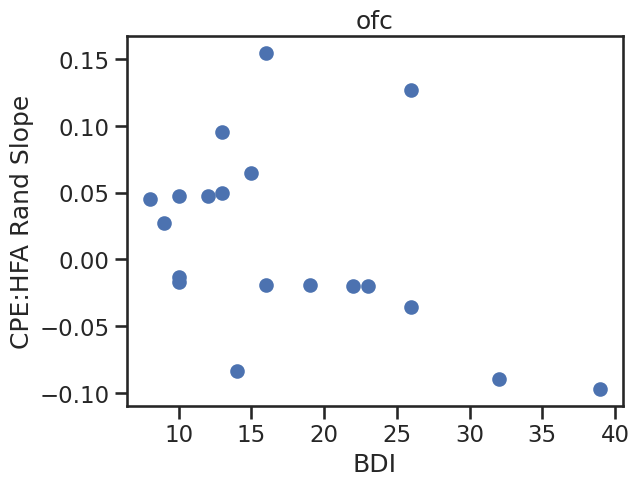

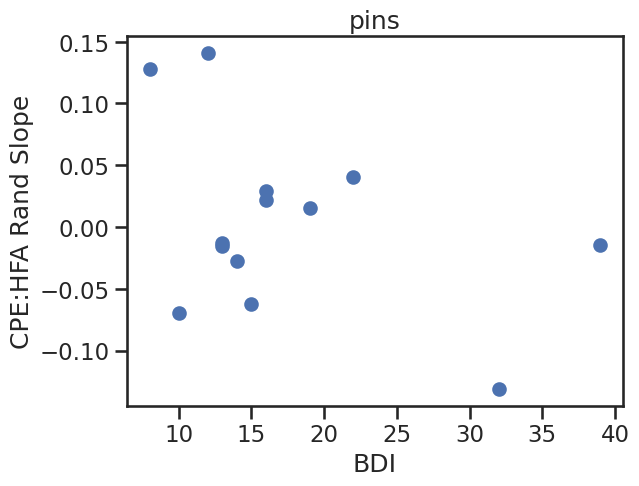

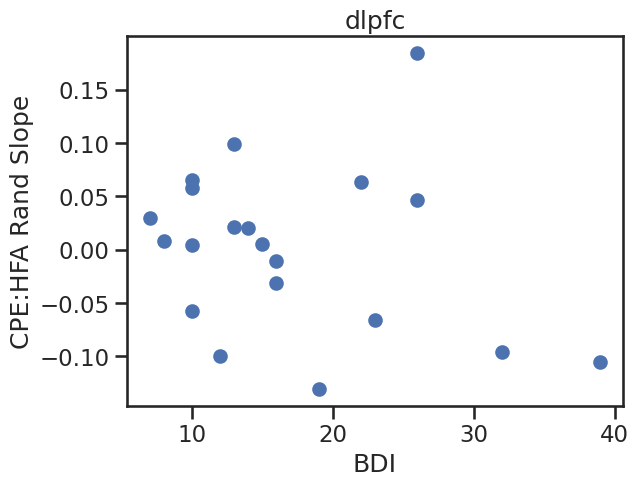

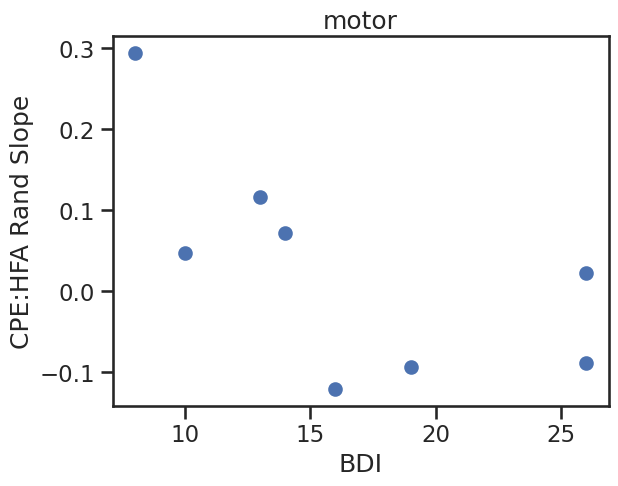

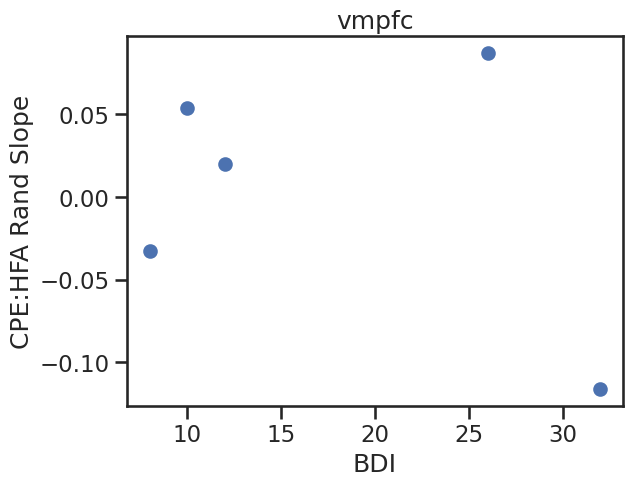

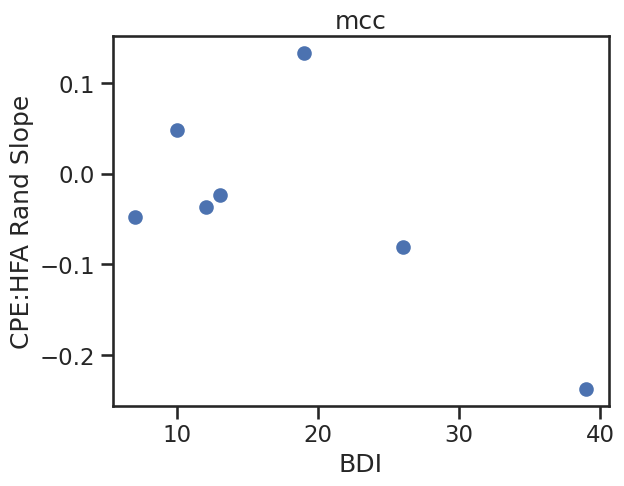

In [458]:

for roi in roi_list:
    roi_data = roi_subj_means_plot[roi_subj_means_plot.index.isin([roi],level=1)]
    roi_subj = roi_data.index.get_level_values(level='subj_id').values.tolist()
    roi_subj_bdi = subj_info_df.bdi[subj_info_df.subj_id.isin(roi_subj)].tolist()
    r,p_r = pearsonr(roi_subj_bdi,roi_data.rand_cpe_hfa_slopes.values)
    print(roi,r,p_r)
    plt.figure()
    plt.scatter(roi_subj_bdi,roi_data.rand_cpe_hfa_slopes.values)
    plt.title(f'{roi}')
    plt.xlabel('BDI')
    plt.ylabel('CPE:HFA Rand Slope')
    
    

In [ ]:
sns.set_context('talk')
plt.scatter(subj_info_df.bdi,subj_means_plot.rand_cpe_hfa_slopes)